In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import re
import jieba
import jieba.analyse
import math
from nltk import ngrams, FreqDist
from collections import Counter, namedtuple

import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib as mpl
from matplotlib.font_manager import fontManager
import matplotlib.font_manager


fontManager.addfont('./TaipeiSansTCBeta-Regular.ttf')
FontPath = './TaipeiSansTCBeta-Regular.ttf' # 設定字型
a = sorted([f.name for f in matplotlib.font_manager.fontManager.ttflist])
for i in a:
    print(i)
    plt.rcParams['font.size'] = 12
mpl.rc('font', family='Taipei Sans TC Beta')

pd.reset_option('display.max_rows') #省略顯示
#pd.reset_option('display.max_columns')
#pd.set_option('display.max_rows', None)#完整顯示

In [2]:
# 設定圖的中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
# plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示

In [3]:
#匯入資料
df = pd.read_csv('text.csv', encoding = 'UTF-8')
df.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,safelove,marriage,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""FlyOncidium""...",114.137.169.105,2021-01-10 01:20:56,ptt
1,2,https://www.ptt.cc/bbs/marriage/M.1610162736.A...,Re:老公工作不穩定,2021-01-09 11:25:34,mayko,marriage,"因為男方工作不穩定,房東才不肯租,只好換女生承租,對吧\n很殘忍的說...這無緣的孩子聰明,...",[],36.229.84.229,2021-01-10 01:20:56,ptt
2,3,https://www.ptt.cc/bbs/marriage/M.1610190309.A...,Re:[求助]真的可以不給看手機嗎？,2021-01-09 19:05:00,loser1,marriage,手機要看就給看啊！\n先帝爺不是說，\n一隻不夠，不能辦兩隻嗎？\n兩隻不夠，不能辦三隻嗎？...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""mark0204"", ""...",118.170.238.138,2021-01-10 01:20:56,ptt


In [4]:
MetaData = df.copy()

# 去除一些不需要的欄位
MetaData = MetaData.drop(['artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource'], axis=1)
# 只留下中文字
MetaData['sentence'] = MetaData['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

MetaData.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence
0,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,常常看大家說偷看手機是不對的但如果已經結婚了太太想看你手機真的可以拒絕嗎感覺你拒絕就是心裡有...
1,2,https://www.ptt.cc/bbs/marriage/M.1610162736.A...,Re:老公工作不穩定,2021-01-09 11:25:34,"因為男方工作不穩定,房東才不肯租,只好換女生承租,對吧\n很殘忍的說...這無緣的孩子聰明,...",因為男方工作不穩定房東才不肯租只好換女生承租對吧很殘忍的說這無緣的孩子聰明來到這世間只是苦難...
2,3,https://www.ptt.cc/bbs/marriage/M.1610190309.A...,Re:[求助]真的可以不給看手機嗎？,2021-01-09 19:05:00,手機要看就給看啊！\n先帝爺不是說，\n一隻不夠，不能辦兩隻嗎？\n兩隻不夠，不能辦三隻嗎？...,手機要看就給看啊先帝爺不是說一隻不夠不能辦兩隻嗎兩隻不夠不能辦三隻嗎三隻四隻不夠可以辦五隻十...


In [5]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

# 新增stopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [6]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數小於1的詞彙

    return seg_list

In [7]:
data = MetaData.copy()

# 斷詞、去除停用字並將word欄位展開
data['word'] = data.sentence.apply(getToken).explode('word')

data.head(3)

Building prefix dict from /home/shiehpay/SMA_2025S/SMA_2025S/homework/divorce/dict/dict.txt.big ...
Loading model from cache /tmp/jieba.ue7304271e7e63b6ba0e49a7adafea804.cache
Loading model cost 1.063 seconds.
Prefix dict has been built successfully.


,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,常常看大家說偷看手機是不對的但如果已經結婚了太太想看你手機真的可以拒絕嗎感覺你拒絕就是心裡有...,偷看
1,2,https://www.ptt.cc/bbs/marriage/M.1610162736.A...,Re:老公工作不穩定,2021-01-09 11:25:34,"因為男方工作不穩定,房東才不肯租,只好換女生承租,對吧\n很殘忍的說...這無緣的孩子聰明,...",因為男方工作不穩定房東才不肯租只好換女生承租對吧很殘忍的說這無緣的孩子聰明來到這世間只是苦難...,手機
2,3,https://www.ptt.cc/bbs/marriage/M.1610190309.A...,Re:[求助]真的可以不給看手機嗎？,2021-01-09 19:05:00,手機要看就給看啊！\n先帝爺不是說，\n一隻不夠，不能辦兩隻嗎？\n兩隻不夠，不能辦三隻嗎？...,手機要看就給看啊先帝爺不是說一隻不夠不能辦兩隻嗎兩隻不夠不能辦三隻嗎三隻四隻不夠可以辦五隻十...,手機


In [8]:
data['sentence'] = data['sentence'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))
data = data.assign(word = data['sentence'].apply(getToken)).explode('word')

data.head()

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,常常看大家說偷看手機是不對的但如果已經結婚了太太想看你手機真的可以拒絕嗎感覺你拒絕就是心裡有...,偷看
0,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,常常看大家說偷看手機是不對的但如果已經結婚了太太想看你手機真的可以拒絕嗎感覺你拒絕就是心裡有...,手機
0,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,常常看大家說偷看手機是不對的但如果已經結婚了太太想看你手機真的可以拒絕嗎感覺你拒絕就是心裡有...,手機
0,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,常常看大家說偷看手機是不對的但如果已經結婚了太太想看你手機真的可以拒絕嗎感覺你拒絕就是心裡有...,拒絕
0,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,常常看大家說偷看手機是不對的但如果已經結婚了太太想看你手機真的可以拒絕嗎感覺你拒絕就是心裡有...,拒絕


TF-IDF公式計算(sklearn)

In [9]:
divoce_df = MetaData.copy()
divoce_df.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence
0,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,常常看大家說偷看手機是不對的但如果已經結婚了太太想看你手機真的可以拒絕嗎感覺你拒絕就是心裡有...
1,2,https://www.ptt.cc/bbs/marriage/M.1610162736.A...,Re:老公工作不穩定,2021-01-09 11:25:34,"因為男方工作不穩定,房東才不肯租,只好換女生承租,對吧\n很殘忍的說...這無緣的孩子聰明,...",因為男方工作不穩定房東才不肯租只好換女生承租對吧很殘忍的說這無緣的孩子聰明來到這世間只是苦難...
2,3,https://www.ptt.cc/bbs/marriage/M.1610190309.A...,Re:[求助]真的可以不給看手機嗎？,2021-01-09 19:05:00,手機要看就給看啊！\n先帝爺不是說，\n一隻不夠，不能辦兩隻嗎？\n兩隻不夠，不能辦三隻嗎？...,手機要看就給看啊先帝爺不是說一隻不夠不能辦兩隻嗎兩隻不夠不能辦三隻嗎三隻四隻不夠可以辦五隻十...


In [10]:
# 保留需要的欄位
divoce_df = divoce_df.loc[:,["system_id", "sentence"]]

# 改成使用空格連接斷完的詞
divoce_df['word'] = divoce_df.sentence.apply(getToken).map(' '.join)

divoce_df.head()

,system_id,sentence,word
0,1,常常看大家說偷看手機是不對的但如果已經結婚了太太想看你手機真的可以拒絕嗎感覺你拒絕就是心裡有...,偷看 手機 手機 拒絕 拒絕 心裡 有鬼 猜忌 日子 難過 手機 隨便 提心吊膽 小心 總是...
1,2,因為男方工作不穩定房東才不肯租只好換女生承租對吧很殘忍的說這無緣的孩子聰明來到這世間只是苦難...,工作 穩定 房東 不肯 只好 承租 殘忍 無緣 聰明 來到 世間 苦難 不來 考慮 信貸 申...
2,3,手機要看就給看啊先帝爺不是說一隻不夠不能辦兩隻嗎兩隻不夠不能辦三隻嗎三隻四隻不夠可以辦五隻十...,手機 給看 先帝 一隻 不夠 兩隻 兩隻 不夠 三隻 三隻 四隻 不夠 五隻 十隻 怕人 重...
3,4,其實都是小事但都可以吵到離婚可能我們就是幾歲的小孩昨晚上床睡覺後一直覺得很冷老公也喊冷想說睡...,小事 吵到 幾歲 昨晚 上床 睡覺 冷想 溫暖 半夜 突然 冷醒 發覺 手腳 冰冷 衣服 襪...
4,5,把棉被翻好正面嗯嗯有嗯那你幹嘛抱怨你老公不是誰上床睡覺還會檢查棉被正反的嗎我我也覺得你半夜叫...,棉被 正面 幹嘛 抱怨 上床 睡覺 檢查 棉被 正反 半夜 了講 一句 明顯 吵架 綠茶 早...


In [11]:
# Bag of Word
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(divoce_df["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成 dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,一一,一丁點,一三五,一下下,一下子,一下床,一下手,一不小心,一不注意,一世,...,龍套,龍心,龍星,龍蝦,龍頭,龐大,龜兒子,龜毛,龜當,龜裂
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2199,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2200,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2201,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2202,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
transformer = TfidfTransformer()  
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())

TFIDF_df

,一一,一丁點,一三五,一下下,一下子,一下床,一下手,一不小心,一不注意,一世,...,龍套,龍心,龍星,龍蝦,龍頭,龐大,龜兒子,龜毛,龜當,龜裂
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2202,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 方法1： 取每一個字詞在所有文件裡的TF-IDF平均值

In [13]:
divoce_tfidf = TFIDF_df.mean().to_frame().reset_index() ## !!
divoce_tfidf.columns = ["word", "avg"]

divoce_tfidf.sort_values('avg', ascending = False).head(10)

,word,avg
9162,問題,0.024528
13817,工作,0.020794
12787,家庭,0.016197
25570,生活,0.015980
14715,建議,0.015440
20389,時間,0.014758
23826,溝通,0.012893
24538,照顧,0.012634
14000,希望,0.012532
38745,願意,0.011363


In [14]:
toptens = TFIDF_df.copy()
toptens.insert(0, 'doc_id', toptens.index+1)

toptens

,doc_id,一一,一丁點,一三五,一下下,一下子,一下床,一下手,一不小心,一不注意,...,龍套,龍心,龍星,龍蝦,龍頭,龐大,龜兒子,龜毛,龜當,龜裂
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2199,2200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2200,2201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2201,2202,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2202,2203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
toptens = toptens.melt(id_vars = "doc_id", var_name = "word", value_name = 'tfidf')
toptens

,doc_id,word,tfidf
0,1,一一,0.0
1,2,一一,0.0
2,3,一一,0.0
3,4,一一,0.0
4,5,一一,0.0
...,...,...,...
87586955,2200,龜裂,0.0
87586956,2201,龜裂,0.0
87586957,2202,龜裂,0.0
87586958,2203,龜裂,0.0


In [16]:
(
    # 從每篇文章挑選出tf-idf最大的前十個詞
    toptens.groupby("doc_id").apply(lambda x : x.nlargest(10, "tfidf")).reset_index(drop=True)
   
    # 計算每個詞被選中的次數
    .groupby(['word'],as_index=False).size()

).sort_values('size', ascending=False).head(10) # 排序看前十名

/tmp/ipykernel_124811/3283726584.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  toptens.groupby("doc_id").apply(lambda x : x.nlargest(10, "tfidf")).reset_index(drop=True)


,word,size
4828,工作,78
3219,問題,56
9604,美國,39
4481,家庭,36
10732,財產,35
7951,溝通,35
3646,外遇,35
6672,改變,34
8172,照顧,33
1882,公公,30


Bigram

In [17]:
# 設定 ngram 斷詞 function
def ngram_getToken(row, n):
    # 進行斷詞
    seg_list = jieba.lcut(row)

    # 篩選掉停用字與字元數小於1的詞彙
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]

    # ngram斷詞
    seg_list = ngrams(seg_list, n)
    seg_list = [" ".join(w) for w in list(seg_list)]
    
    return seg_list

In [18]:
divoce_bigram = MetaData.copy()

divoce_bigram['word'] = divoce_bigram['sentence'].apply(lambda row:ngram_getToken(row, 2))
divoce_bigram = divoce_bigram.explode('word')

divoce_bigram.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,常常看大家說偷看手機是不對的但如果已經結婚了太太想看你手機真的可以拒絕嗎感覺你拒絕就是心裡有...,偷看 手機
0,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,常常看大家說偷看手機是不對的但如果已經結婚了太太想看你手機真的可以拒絕嗎感覺你拒絕就是心裡有...,手機 手機
0,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,常常看大家說偷看手機是不對的但如果已經結婚了太太想看你手機真的可以拒絕嗎感覺你拒絕就是心裡有...,手機 拒絕


In [21]:
divoce_bigram = MetaData.copy()

divoce_bigram["word"] = divoce_bigram['sentence'].apply(lambda row: ngram_getToken(row, 2))
divoce_bigram = divoce_bigram.explode('word')

divoce_bigram.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,常常看大家說偷看手機是不對的但如果已經結婚了太太想看你手機真的可以拒絕嗎感覺你拒絕就是心裡有...,偷看 手機
0,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,常常看大家說偷看手機是不對的但如果已經結婚了太太想看你手機真的可以拒絕嗎感覺你拒絕就是心裡有...,手機 手機
0,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,常常看大家說偷看手機是不對的但如果已經結婚了太太想看你手機真的可以拒絕嗎感覺你拒絕就是心裡有...,手機 拒絕


In [19]:
# 計算每個組合出現的次數
divoce_bigram_count = divoce_bigram['word'].value_counts().reset_index()

divoce_bigram_count.sort_values('count', ascending=False).head(10)

,word,count
0,同意 記者,220
1,記者 抄文,192
2,原生 家庭,142
3,情緒 勒索,109
4,問題 解決,59
5,經濟 能力,55
6,問題 問題,47
7,解決 問題,47
10,這段 時間,42
8,婆媳 問題,42


Trigram

In [21]:
divoce_trigram = MetaData.copy()

divoce_trigram["word"] = divoce_trigram.sentence.apply(lambda row: ngram_getToken(row, 3))
divoce_trigram = divoce_trigram.explode('word')

divoce_trigram.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,常常看大家說偷看手機是不對的但如果已經結婚了太太想看你手機真的可以拒絕嗎感覺你拒絕就是心裡有...,偷看 手機 手機
0,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,常常看大家說偷看手機是不對的但如果已經結婚了太太想看你手機真的可以拒絕嗎感覺你拒絕就是心裡有...,手機 手機 拒絕
0,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,常常看大家說偷看手機是不對的但如果已經結婚了太太想看你手機真的可以拒絕嗎感覺你拒絕就是心裡有...,手機 拒絕 拒絕


In [23]:
# 計算每個組合出現的次數
divoce_trigram_count = divoce_trigram['word'].value_counts().reset_index()

divoce_trigram_count.sort_values('count', ascending=False).head(10)

,word,count
0,同意 記者 抄文,189
2,以下 同意 記者,37
3,控制 碼請 刪掉,37
1,顏色 控制 碼請,37
4,刪掉 以下 同意,30
5,碼請 刪掉 以下,30
6,英文 叫做 比喻,17
7,剩餘 財產 分配,17
8,發生 問題 建議,17
9,描述 問題 前因後果,16


In [24]:
# 新增離婚相關自定義字典
jieba.load_userdict('./dict/divoce_lexicon.txt')

In [25]:
# 剛才的斷詞結果沒有使用新增的辭典，因此我們重新進行斷詞
data2 = MetaData.copy()
data2['word'] = data2.sentence.apply(getToken)
data2 = data2.explode('word')

data2.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,常常看大家說偷看手機是不對的但如果已經結婚了太太想看你手機真的可以拒絕嗎感覺你拒絕就是心裡有...,偷看
0,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,常常看大家說偷看手機是不對的但如果已經結婚了太太想看你手機真的可以拒絕嗎感覺你拒絕就是心裡有...,手機
0,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,常常看大家說偷看手機是不對的但如果已經結婚了太太想看你手機真的可以拒絕嗎感覺你拒絕就是心裡有...,手機


Bigram視覺化

In [26]:
bigramfdist = MetaData.copy()

bigramfdist["word"] = bigramfdist['sentence'].apply(lambda row: ngram_getToken(row, 2))
bigramfdist = bigramfdist.explode('word')

bigramfdist.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,常常看大家說偷看手機是不對的但如果已經結婚了太太想看你手機真的可以拒絕嗎感覺你拒絕就是心裡有...,偷看 手機
0,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,常常看大家說偷看手機是不對的但如果已經結婚了太太想看你手機真的可以拒絕嗎感覺你拒絕就是心裡有...,手機 手機
0,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,常常看大家說偷看手機是不對的但如果已經結婚了太太想看你手機真的可以拒絕嗎感覺你拒絕就是心裡有...,手機 拒絕


In [27]:
bigramfdist['word'] = bigramfdist['word'].astype(str)

# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist(bigramfdist['word'].apply(lambda x: tuple(x.split(' '))))
bigramfdist.most_common(5)

[(('同意', '記者'), 220),
 (('記者', '抄文'), 192),
 (('原生', '家庭'), 142),
 (('情緒', '勒索'), 109),
 (('問題', '解決'), 59)]

In [28]:
# 建立bigram和count的dictionary
# 這裡取最多的前50項
d = {k:v for k,v in bigramfdist.most_common(50)}

In [29]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v) # nodes：詞彙，weight：組合出現頻率
    
# 取得調整edge權重
weights = [w[2]['weight']*0.01 for w in  G.edges(data=True)]

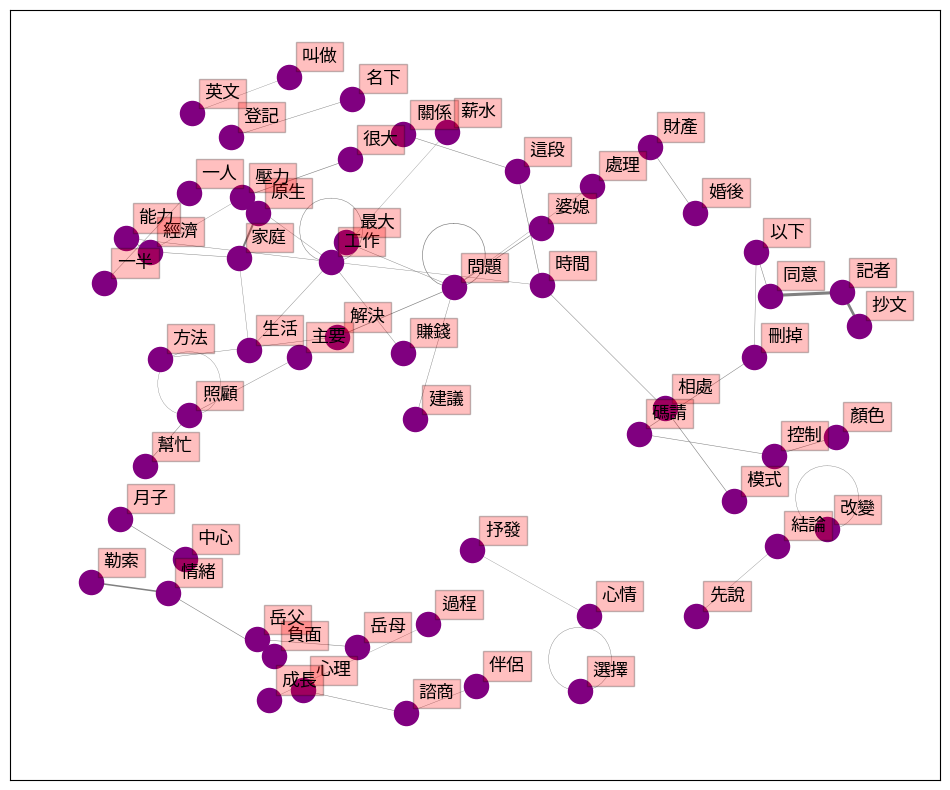

In [30]:
# 設定 matplotlib 全域字型（以微軟正黑體為例）
# plt.rcParams['font.family'] = 'Microsoft JhengHei'
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題
fig, ax = plt.subplots(figsize=(12, 10))

pos = nx.spring_layout(G, k=1.5)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

以上圖可以觀察到

🧩 問題處理與情緒調節
關鍵詞：「問題」「控制」「處理」「心理」「情緒」「解決」「建議」

說明：反映當事人面對婚姻問題時的思考與應對策略，強調如何處理關係中的衝突與壓力。

💸 生活壓力與經濟現實
關鍵詞：「工作」「薪水」「能力」「經濟」「負面」「壓力」

說明：顯示出經濟問題、賺錢壓力、工作影響是離婚的重要背景因素之一。

🏠 家庭角色與原生關係
關鍵詞：「家庭」「原生」「岳父」「岳母」「照顧」「名下」

說明：婚姻中常常牽涉到長輩、家庭義務與角色衝突，這些外在因素可能導致壓力或誤解。

💔 婚姻關係本身與未來選擇
關鍵詞：「婚後」「財產」「離婚」「伴侶」「選擇」「結論」
說明：聚焦在婚姻關係的變化結果，如財產分配、是否離婚、未來生活選擇


### Pairwise correlation

In [31]:
data_cor = MetaData.copy()

data_cor['word'] = data_cor.sentence.apply(getToken).map(' '.join)
data_cor.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,常常看大家說偷看手機是不對的但如果已經結婚了太太想看你手機真的可以拒絕嗎感覺你拒絕就是心裡有...,偷看 手機 手機 拒絕 拒絕 心裡 有鬼 猜忌 日子 難過 手機 隨便 提心吊膽 小心 總是...
1,2,https://www.ptt.cc/bbs/marriage/M.1610162736.A...,Re:老公工作不穩定,2021-01-09 11:25:34,"因為男方工作不穩定,房東才不肯租,只好換女生承租,對吧\n很殘忍的說...這無緣的孩子聰明,...",因為男方工作不穩定房東才不肯租只好換女生承租對吧很殘忍的說這無緣的孩子聰明來到這世間只是苦難...,工作 穩定 房東 不肯 只好 承租 殘忍 無緣 聰明 來到 世間 苦難 不來 考慮 信貸 申...
2,3,https://www.ptt.cc/bbs/marriage/M.1610190309.A...,Re:[求助]真的可以不給看手機嗎？,2021-01-09 19:05:00,手機要看就給看啊！\n先帝爺不是說，\n一隻不夠，不能辦兩隻嗎？\n兩隻不夠，不能辦三隻嗎？...,手機要看就給看啊先帝爺不是說一隻不夠不能辦兩隻嗎兩隻不夠不能辦三隻嗎三隻四隻不夠可以辦五隻十...,手機 給看 先帝 一隻 不夠 兩隻 兩隻 不夠 三隻 三隻 四隻 不夠 五隻 十隻 怕人 重...


In [32]:
vectorizer = CountVectorizer(min_df = 5 , max_features = 200)
X = vectorizer.fit_transform(data_cor['word'])
vocabulary = vectorizer.get_feature_names_out()

DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,一個月,一半,一句,一堆,一天,一種,一輩子,上班,下來,下班,...,重要,重點,長大,長輩,開心,關係,離開,需求,面對,願意
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2199,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2200,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2201,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,1,0
2202,0,0,0,0,0,0,0,0,0,0,...,3,1,0,1,0,0,0,0,1,0


In [33]:
corr_matrix = np.corrcoef(DTM_df.T)

Cor_df = pd.DataFrame(corr_matrix , index = DTM_df.columns, columns = DTM_df.columns)

Cor_df.insert(0, 'word1', Cor_df.columns)
Cor_df.reset_index(inplace = True , drop = True)

Cor_df

,word1,一個月,一半,一句,一堆,一天,一種,一輩子,上班,下來,...,重要,重點,長大,長輩,開心,關係,離開,需求,面對,願意
0,一個月,1.000000,0.049886,0.035742,0.017035,0.141114,-0.014822,0.062134,0.200325,0.109059,...,-0.002533,0.003423,0.031082,0.027455,0.070612,0.010898,0.111718,0.031368,0.008316,0.158358
1,一半,0.049886,1.000000,0.154615,0.009311,0.092468,0.006591,0.002608,0.079252,0.195133,...,0.025005,0.034294,0.073403,0.035901,0.173844,0.040255,0.128884,0.010227,-0.001220,0.083292
2,一句,0.035742,0.154615,1.000000,0.036945,0.145448,0.042438,0.071510,0.060495,0.179276,...,0.064399,0.106672,0.106535,0.003158,0.138400,0.073400,0.105134,0.035186,0.073542,0.122257
3,一堆,0.017035,0.009311,0.036945,1.000000,0.012216,-0.004466,-0.000129,0.038605,0.021666,...,0.068042,0.044764,0.021275,0.035918,0.077554,-0.003055,0.025730,0.013979,0.014258,0.005206
4,一天,0.141114,0.092468,0.145448,0.012216,1.000000,0.095938,0.053808,0.190309,0.104582,...,0.084258,0.000183,0.084834,0.027986,0.111222,0.174810,0.093230,0.109828,0.074169,0.171107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,關係,0.010898,0.040255,0.073400,-0.003055,0.174810,0.174831,0.045732,0.040921,0.055634,...,0.140125,0.020542,0.124288,0.040119,0.101790,1.000000,0.112227,0.241709,0.186452,0.161358
196,離開,0.111718,0.128884,0.105134,0.025730,0.093230,0.046559,0.084628,0.107562,0.210011,...,0.088287,0.013185,0.104317,0.038212,0.150247,0.112227,1.000000,0.055456,0.132763,0.157834
197,需求,0.031368,0.010227,0.035186,0.013979,0.109828,0.181423,0.019131,0.022024,0.064246,...,0.122705,0.016060,0.004804,0.033902,0.078840,0.241709,0.055456,1.000000,0.073603,0.160093
198,面對,0.008316,-0.001220,0.073542,0.014258,0.074169,0.142077,0.094248,0.081262,0.088773,...,0.098563,0.048021,0.084778,0.061551,0.087956,0.186452,0.132763,0.073603,1.000000,0.221320


In [34]:
word_cor_df = Cor_df.melt(id_vars = 'word1', var_name = 'word2' , value_name = 'cor')

word_cor_df = word_cor_df[word_cor_df['word1'] != word_cor_df['word2']]

word_cor_df.sort_values('cor', ascending =False).head(10)

,word1,word2,cor
7961,記者,同意,0.550335
32239,同意,記者,0.550335
26234,努力,痛苦,0.483483
6931,痛苦,努力,0.483483
6841,告訴,努力,0.483276
8234,努力,告訴,0.483276
8331,痛苦,告訴,0.474694
26241,告訴,痛苦,0.474694
12130,生活,工作,0.449528
26060,工作,生活,0.449528


### 和 「溝通」, 「經濟」 相關性最高的 10 個詞彙

In [35]:
div_sum = word_cor_df[(word_cor_df['word1'] == "溝通")].sort_values(by = ['cor'], ascending = False).head(10)
con_sum = word_cor_df[(word_cor_df['word1'] == "經濟")].sort_values(by = ['cor'], ascending = False).head(10)

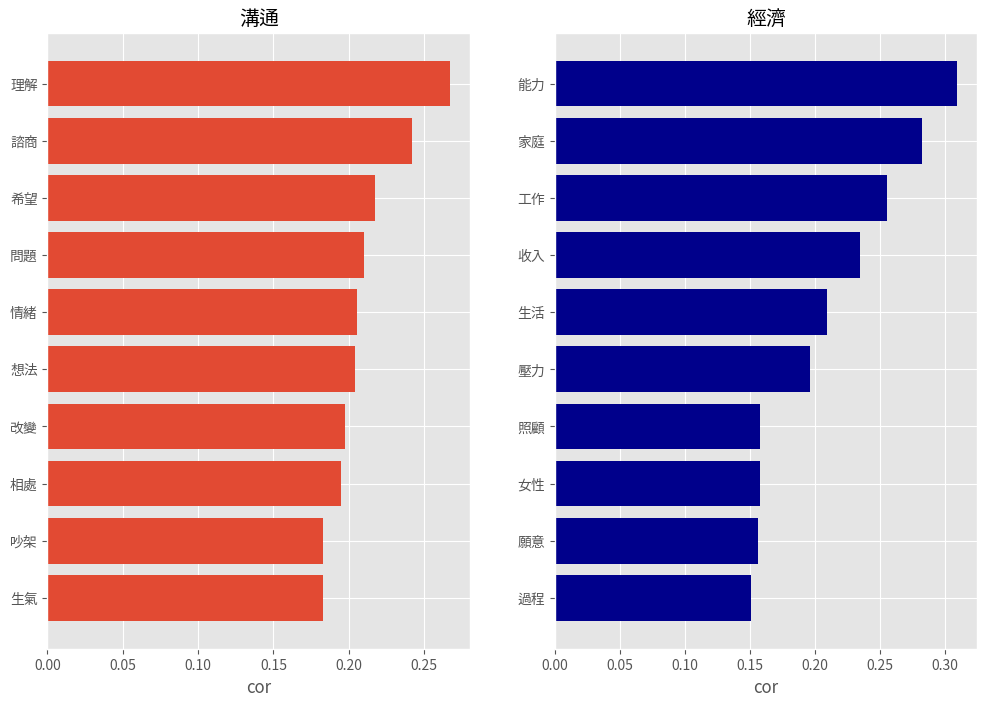

In [36]:
plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('溝通')
plt.xlabel('cor')
plt.barh(div_sum['word2'],div_sum['cor'])
plt.gca().invert_yaxis()

plt.subplot(122)
plt.title('經濟')
plt.xlabel('cor')
plt.barh(con_sum['word2'],con_sum['cor'],color="darkblue")
plt.gca().invert_yaxis()

plt.show()

### 使用詞彙關係圖畫出以詞頻前60為節點且相關性高於0.3的組合

In [37]:
#透過DTM找出詞頻前60高的詞彙
most_freq_df = DTM_df.sum().sort_values(ascending=False).head(60).reset_index().rename(columns={'index':'word', 0:'count'})

most_freq_word = most_freq_df['word'].tolist()

In [38]:
# 保留存在詞頻前60高之詞彙的組合
filtered_df = word_cor_df[(word_cor_df['word1'].isin(most_freq_word)) & (word_cor_df['word2'].isin(most_freq_word))]

# 篩選出相關係數大於0.3的組合
filtered_df = filtered_df[filtered_df['cor'] >= 0.28]
filtered_df.reset_index(inplace=True, drop=True)
filtered_df

,word1,word2,cor
0,關係,兩人,0.324178
1,希望,努力,0.381417
2,我會,努力,0.301851
3,時間,努力,0.310105
4,生活,努力,0.287391
...,...,...,...
69,努力,選擇,0.310424
70,兩人,關係,0.324178
71,諮商,關係,0.341037
72,努力,願意,0.345643


In [39]:
# Create network plot 
g = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(filtered_df)):
    g.add_edge(filtered_df["word1"][i], filtered_df["word2"][i], weight=filtered_df["cor"][i])
    
# 取得edge權重
weights = [w[2]['weight']*5 for w in  g.edges(data=True)]

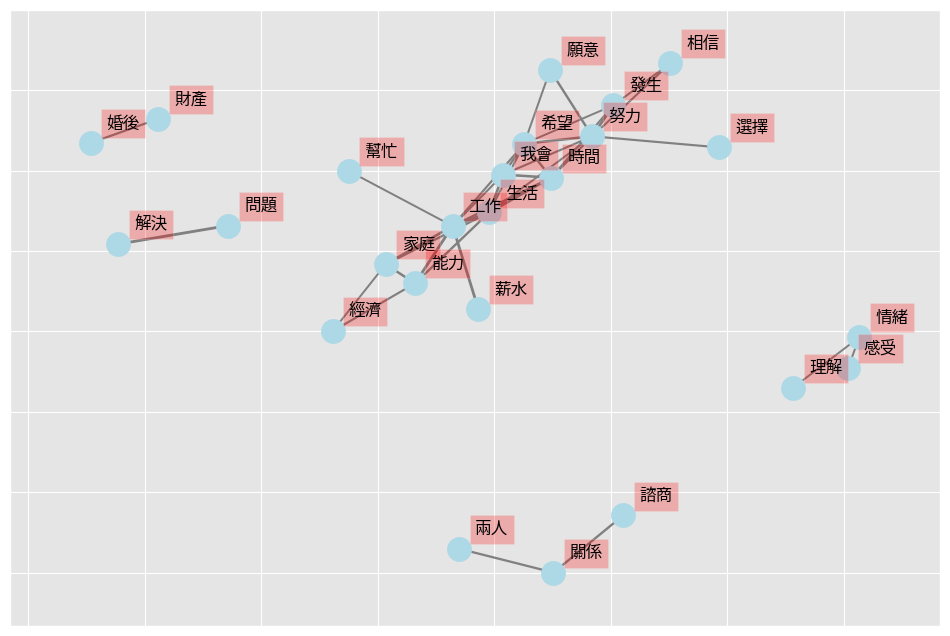

In [40]:
fig, ax = plt.subplots(figsize=(12, 8))

pos = nx.spring_layout(g, k=0.3)

# networks
nx.draw_networkx(g, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=12)
    
plt.show()

這張詞彙關係圖透過網絡結構，呈現了離婚議題討論中最常出現的關鍵詞以及它們之間的連結。從圖中可以看到幾個主要的關聯群集：

1. 婚姻財產與關係（左上）

- 婚後的財產問題會直接影響夫妻之間的關係，甚至可能演變到需要尋求諮商協助
- 財務問題常常是婚姻衝突的起點之一

2. 問題解決（右上）

- 關鍵詞像「問題」連到「解決」，顯示大家在婚姻中很關注怎麼處理衝突或困難

3. 情感理解群集（左下）

- 表達情緒和被理解的需求，也是維持關係的方法

4. 工作－生活－家庭核心網絡（中央）

- 以「工作」、「家庭」、「生活」為中心，延伸出「能力」、「經濟」、「幫忙」等相關詞彙
- 這個複雜的網絡反映出工作、家庭和生活之間的緊密連結
- 像「經濟」同時連到「家庭」和「工作」，說明經濟壓力在家庭關係中扮演著中介角色

5. 積極努力與希望群集（右下）

- 「努力」這個詞連到「希望」、「發生」、「相信」、「願意」等詞
- 這組詞彙代表了在婚姻面臨困難時，維繫關係所需要的信念和行動

---

綜合分析

整張網絡圖揭示了婚姻與離婚議題的多面向性，主要可以歸納為以下幾點：

- 財務與財產問題是最核心、最容易引爆爭議的源頭  
- 情感溝通和相互理解，是維繫關係的情感基礎  
- 工作、生活與家庭的平衡，是婚姻日常中最常見的壓力來源  
- 有效的問題解決能力，以及維持一份積極努力的態度，是穩定關係的關鍵


### 計算文章相似度

In [41]:
data_cos = data_cor.copy()
data_cos.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,常常看大家說偷看手機是不對的但如果已經結婚了太太想看你手機真的可以拒絕嗎感覺你拒絕就是心裡有...,偷看 手機 手機 拒絕 拒絕 心裡 有鬼 猜忌 日子 難過 手機 隨便 提心吊膽 小心 總是...
1,2,https://www.ptt.cc/bbs/marriage/M.1610162736.A...,Re:老公工作不穩定,2021-01-09 11:25:34,"因為男方工作不穩定,房東才不肯租,只好換女生承租,對吧\n很殘忍的說...這無緣的孩子聰明,...",因為男方工作不穩定房東才不肯租只好換女生承租對吧很殘忍的說這無緣的孩子聰明來到這世間只是苦難...,工作 穩定 房東 不肯 只好 承租 殘忍 無緣 聰明 來到 世間 苦難 不來 考慮 信貸 申...
2,3,https://www.ptt.cc/bbs/marriage/M.1610190309.A...,Re:[求助]真的可以不給看手機嗎？,2021-01-09 19:05:00,手機要看就給看啊！\n先帝爺不是說，\n一隻不夠，不能辦兩隻嗎？\n兩隻不夠，不能辦三隻嗎？...,手機要看就給看啊先帝爺不是說一隻不夠不能辦兩隻嗎兩隻不夠不能辦三隻嗎三隻四隻不夠可以辦五隻十...,手機 給看 先帝 一隻 不夠 兩隻 兩隻 不夠 三隻 三隻 四隻 不夠 五隻 十隻 怕人 重...


In [42]:
transformer = TfidfTransformer()
print(transformer)
tfidf = transformer.fit_transform(X)

TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())
TFIDF_df

TfidfTransformer()


,一個月,一半,一句,一堆,一天,一種,一輩子,上班,下來,下班,...,重要,重點,長大,長輩,開心,關係,離開,需求,面對,願意
0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000
1,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000
2,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.471181,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000
3,0.0,0.000000,0.119960,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000
4,0.0,0.000000,0.389462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2199,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.0,0.000000,0.000000,0.272793,0.00000,0.0,0.000000,0.261035
2200,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.28496,0.0,0.000000,0.000000
2201,0.0,0.121818,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.0,0.000000,0.214685,0.000000,0.00000,0.0,0.115673,0.000000
2202,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.45284,0.174411,0.0,0.202036,0.000000,0.000000,0.00000,0.0,0.176520,0.000000


In [43]:
cosine_matrix = cosine_similarity(tfidf.toarray(), tfidf.toarray())

In [44]:
cos_df = pd.DataFrame(cosine_matrix[0], columns = ['cos_similarity'])
cos_df

,cos_similarity
0,1.000000
1,0.000000
2,0.399737
3,0.092796
4,0.000000
...,...
2199,0.000000
2200,0.000000
2201,0.000000
2202,0.000000


In [45]:
cos_df = cos_df.merge(data_cos, how = 'left', left_index=True, right_index=True)
cos_df.loc[:,["cos_similarity", "artTitle", "artUrl"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

,cos_similarity,artTitle,artUrl
0,1.000000,[求助]真的可以不給看手機嗎？,https://www.ptt.cc/bbs/marriage/M.1610159827.A...
354,0.818640,Re:[心情]不懂老公在想什麼？,https://www.ptt.cc/bbs/marriage/M.1626416435.A...
538,0.728742,[閒聊]一直滑手機是因為太無聊,https://www.ptt.cc/bbs/marriage/M.1634023811.A...
96,0.652961,先生上班找援交,https://www.ptt.cc/bbs/marriage/M.1613943928.A...
932,0.639000,[心情]最後一哩路,https://www.ptt.cc/bbs/marriage/M.1651982756.A...
1139,0.638714,Re:[求助]我該跟他談嗎？,https://www.ptt.cc/bbs/marriage/M.1658458889.A...
1334,0.610310,[求助]先生使用zenly(冰棒）追蹤女生,https://www.ptt.cc/bbs/marriage/M.1670856234.A...
533,0.566953,[求助]這樣的婚姻還值得存續嗎？,https://www.ptt.cc/bbs/marriage/M.1633611389.A...
1531,0.551317,Re:[閒聊]不想融入婆家的大家庭,https://www.ptt.cc/bbs/marriage/M.1689042822.A...
387,0.536304,Re:[求助]這樣該離婚嗎？對方不肯怎麼辦,https://www.ptt.cc/bbs/marriage/M.1627760110.A...


In [46]:
cos_df_num = pd.DataFrame(cosine_matrix[354], columns=['cos_similarity'])

cos_df_num = cos_df_num.merge(data_cos, how = 'left', left_index=True, right_index=True)
cos_df_num.loc[:,["cos_similarity", "artTitle", "artUrl"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

,cos_similarity,artTitle,artUrl
354,1.000000,Re:[心情]不懂老公在想什麼？,https://www.ptt.cc/bbs/marriage/M.1626416435.A...
538,0.890186,[閒聊]一直滑手機是因為太無聊,https://www.ptt.cc/bbs/marriage/M.1634023811.A...
0,0.818640,[求助]真的可以不給看手機嗎？,https://www.ptt.cc/bbs/marriage/M.1610159827.A...
96,0.797617,先生上班找援交,https://www.ptt.cc/bbs/marriage/M.1613943928.A...
1139,0.780213,Re:[求助]我該跟他談嗎？,https://www.ptt.cc/bbs/marriage/M.1658458889.A...
533,0.692554,[求助]這樣的婚姻還值得存續嗎？,https://www.ptt.cc/bbs/marriage/M.1633611389.A...
1531,0.673455,Re:[閒聊]不想融入婆家的大家庭,https://www.ptt.cc/bbs/marriage/M.1689042822.A...
1561,0.646286,[求助]無性婚姻，離婚請益,https://www.ptt.cc/bbs/marriage/M.1691718432.A...
2034,0.641591,Re:[求助]怎麼讓老公變得更浪漫？,https://www.ptt.cc/bbs/marriage/M.1721773233.A...
932,0.635770,[心情]最後一哩路,https://www.ptt.cc/bbs/marriage/M.1651982756.A...


### 建立Ngram預測模型

In [47]:
data_n = MetaData.copy()
sen_tokens = data_n.sentence.apply(getToken).tolist()

In [48]:
def ngram(documents, N=2):
    ngram_prediction = dict()
    total_grams = list()
    words = list()
    Word = namedtuple('Word', ['word', 'prob'])

    for doc in documents:
        # 加上開頭和結尾 tag
        split_words = ['<s>'] + list(doc) + ['</s>']
        # 計算分子
        [total_grams.append(tuple(split_words[i:i+N])) for i in range(len(split_words)-N+1)]
        # 計算分母
        [words.append(tuple(split_words[i:i+N-1])) for i in range(len(split_words)-N+2)]
        
    total_word_counter = Counter(total_grams)
    word_counter = Counter(words)
    
    for key in total_word_counter:
        word = ''.join(key[:N-1])
        if word not in ngram_prediction:
            ngram_prediction.update({word: set()})
            
        next_word_prob = total_word_counter[key]/word_counter[key[:N-1]] #P(B|A)
        w = Word(key[-1], '{:.3g}'.format(next_word_prob))
        ngram_prediction[word].add(w)
        
    return ngram_prediction


In [49]:
bi_prediction = ngram(sen_tokens, N=2)

In [50]:
text = '婚後'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 財產, probability: 0.0852
next word: 生活, probability: 0.0219
next word: 工作, probability: 0.017
next word: 生小孩, probability: 0.0146
next word: 每年, probability: 0.00973


這顯示在離婚討論中，財產問題是婚後最被關注的核心議題

In [51]:
text = '財產'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 一半, probability: 0.0312
next word: 分開, probability: 0.0284
next word: 共有, probability: 0.0227
next word: 差額, probability: 0.0199
next word: 婚後, probability: 0.017


離婚討論中財產分配的焦點在於平均分配和分離問題

In [52]:
text = '情緒'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 勒索, probability: 0.141
next word: 價值, probability: 0.0246
next word: 控管, probability: 0.0246
next word: 失控, probability: 0.022
next word: 問題, probability: 0.0207


婚姻關係中不健康的情緒操控可能是導致離婚的關鍵因素

In [53]:
text = '工作'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 工作, probability: 0.0195
next word: 生活, probability: 0.0163
next word: 賺錢, probability: 0.0163
next word: 能力, probability: 0.0163
next word: 壓力, probability: 0.0152


可以看出工作不只是經濟來源，還與生活平衡、能力和壓力相連

In [54]:
text = '家庭'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 經濟, probability: 0.0256
next word: 生活, probability: 0.0216
next word: 問題, probability: 0.016
next word: 關係, probability: 0.0144
next word: 開銷, probability: 0.0128


在婚姻生活和離婚談判中，財產問題往往是大家最關心的焦點之一。
而在日常相處裡，情緒互動，特別是負面情緒的操控，也是一個很大的挑戰，常常影響彼此的關係。
再加上工作壓力和經濟負擔，也會直接衝擊到婚姻的穩定，這些風險真的不能忽視。
婚後生活本來就充滿各種調整與挑戰，稍不留意就可能變成衝突的導火線。

綜合來看，現代婚姻要走得長久，最重要的還是三個關鍵：財務管理、情緒健康和工作生活的平衡。這三個面向也正是人們在考慮離婚時，最常放在心上的核心問題。

# Week 7

### 套件

In [ ]:
import re
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

設定中文字體

In [ ]:
# 設定圖的中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
# plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] #使圖中中文能正常顯示
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示

## 文字前處理
`ppt_merged.csv`
- 版別：婚姻版 食物版 電影版
- 時間範圍：2025/01/01 ~ 2025/04/01
- 工作流程平台搜尋/排除關鍵字：無

首先我們先看文集的基本資料，並做文集前處理。

In [ ]:
df = pd.read_csv("ppt_merged.csv")  # 婚姻版 食物版 電影版 合併後的檔案
df.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Food/M.1735683352.A.8CC...,[轉讓]旭集信義1/7下午茶,2025-01-01 6:15:50,linein,Food,餐廳名稱：旭集\n時間：1/7下午14：30\n人數二位\n訂金1000元\n\n站內信，謝謝\n,[],27.240.177.25,2025-01-02 1:04:00,ptt
1,2,https://www.ptt.cc/bbs/Food/M.1735713718.A.3B1...,[食記]新北中和區｜老味噌居酒屋景安店,2025-01-01 14:41:54,roger31311,Food,餐廳名稱：老味噌居酒屋 景安店\n消費時間：2024年/12月\n地址：新北市中和區景平路4...,[],61.231.20.71,2025-01-02 1:04:00,ptt
2,3,https://www.ptt.cc/bbs/Food/M.1735717080.A.B96...,[食記]花蓮養鍋漂亮好吃的石頭火鍋,2025-01-01 15:37:57,lovecala,Food,餐廳名稱：養鍋\n 消費時間：2025年/1月\n 地址：花蓮市中山路549-1號\...,[],114.43.215.209,2025-01-02 1:04:00,ptt


In [ ]:
# 看看有幾篇文章
print(f"number of posts: {df.shape[0]}")
print(f"date range: {(df['artDate'].min(), df['artDate'].max())}")
print(f"category: \n{df['artCatagory'].value_counts()}")

number of posts: 6374
date range: ('2025-01-01 0:56:25', '2025-04-01 4:34:16')
category: 
artCatagory
movie       4522
Food        1312
marriage     540
Name: count, dtype: int64


### 清理

利用問號、句號或驚嘆號等符號斷句，或是如果出現中文或是英文的省略號，像是`...`也會斷句，最後設定會去除結尾的空白符號。

In [ ]:
# 過濾 nan 的資料
df = df.dropna(subset=['artTitle'])
df = df.dropna(subset=['artContent'])
# 移除網址格式
df["artContent"] = df.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
df["artTitle"] = df["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 只留下中文字
df["artContent"] = df.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
df["artTitle"] = df["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
df.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Food/M.1735683352.A.8CC...,轉讓旭集信義下午茶,2025-01-01 6:15:50,linein,Food,餐廳名稱旭集時間下午人數二位訂金元站內信謝謝,[],27.240.177.25,2025-01-02 1:04:00,ptt
1,2,https://www.ptt.cc/bbs/Food/M.1735713718.A.3B1...,食記新北中和區老味噌居酒屋景安店,2025-01-01 14:41:54,roger31311,Food,餐廳名稱老味噌居酒屋景安店消費時間年月地址新北市中和區景平路號電話營業時間每人平均價位好讀圖...,[],61.231.20.71,2025-01-02 1:04:00,ptt
2,3,https://www.ptt.cc/bbs/Food/M.1735717080.A.B96...,食記花蓮養鍋漂亮好吃的石頭火鍋,2025-01-01 15:37:57,lovecala,Food,餐廳名稱養鍋消費時間年月地址花蓮市中山路號電話每人平均價位圖文網誌這間養鍋在台北有吃過印象不...,[],114.43.215.209,2025-01-02 1:04:00,ptt


文章的標題`artTitle`和內文`sentence`都會納入分析的內容，成為新的`content`欄位。

In [ ]:
# 留下 content
df["content"] = df["artTitle"] + df["artContent"]
df = df[["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結
df.head()

,content,artUrl,artCatagory
0,轉讓旭集信義下午茶餐廳名稱旭集時間下午人數二位訂金元站內信謝謝,https://www.ptt.cc/bbs/Food/M.1735683352.A.8CC...,Food
1,食記新北中和區老味噌居酒屋景安店餐廳名稱老味噌居酒屋景安店消費時間年月地址新北市中和區景平路...,https://www.ptt.cc/bbs/Food/M.1735713718.A.3B1...,Food
2,食記花蓮養鍋漂亮好吃的石頭火鍋餐廳名稱養鍋消費時間年月地址花蓮市中山路號電話每人平均價位圖文...,https://www.ptt.cc/bbs/Food/M.1735717080.A.B96...,Food
3,食記苗栗後龍北川咖啡鄉間小路質感咖啡店餐廳名稱北川咖啡消費時間年月電話地址苗栗縣後龍鎮八鄰之...,https://www.ptt.cc/bbs/Food/M.1735731925.A.C87...,Food
4,食記東京人形町今半東京紀尾人形町今半東京紀尾井町店地址東京都千代田区紀尾井町東京紀尾井町紀尾...,https://www.ptt.cc/bbs/Food/M.1735738597.A.0CF...,Food


In [ ]:
# 看看有幾篇文章
print(f"total docs: {df.shape[0]}")


total docs: 6368


### 斷詞

In [ ]:
# 設定繁體中文詞庫
jieba.set_dictionary("dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("stopwords.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [ ]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [ ]:
df["words"] = df["content"].apply(getToken).map(" ".join)
df.head()

Building prefix dict from c:\Users\rolya\Desktop\week7\dict.txt.big ...
Loading model from cache C:\Users\rolya\AppData\Local\Temp\jieba.u7b5383afc40a60e5bca88cff9c4ca3dd.cache
Loading model cost 1.368 seconds.
Prefix dict has been built successfully.


,content,artUrl,artCatagory,words
0,轉讓旭集信義下午茶餐廳名稱旭集時間下午人數二位訂金元站內信謝謝,https://www.ptt.cc/bbs/Food/M.1735683352.A.8CC...,Food,轉讓 旭集 信義 下午 茶餐廳 名稱 旭集 時間 下午 人數 二位 金元 謝謝
1,食記新北中和區老味噌居酒屋景安店餐廳名稱老味噌居酒屋景安店消費時間年月地址新北市中和區景平路...,https://www.ptt.cc/bbs/Food/M.1735713718.A.3B1...,Food,食記 新北 中和區 老味 居酒 屋景安店 餐廳 名稱 老味 居酒 屋景安店 消費 時間 地址...
2,食記花蓮養鍋漂亮好吃的石頭火鍋餐廳名稱養鍋消費時間年月地址花蓮市中山路號電話每人平均價位圖文...,https://www.ptt.cc/bbs/Food/M.1735717080.A.B96...,Food,食記 花蓮 養鍋 漂亮 好吃 石頭火鍋 餐廳 名稱 養鍋 消費 時間 地址 花蓮市 中山路 ...
3,食記苗栗後龍北川咖啡鄉間小路質感咖啡店餐廳名稱北川咖啡消費時間年月電話地址苗栗縣後龍鎮八鄰之...,https://www.ptt.cc/bbs/Food/M.1735731925.A.C87...,Food,食記 苗栗 北川 咖啡 鄉間 小路 質感 咖啡店 餐廳 名稱 北川 咖啡 消費 時間 電話 ...
4,食記東京人形町今半東京紀尾人形町今半東京紀尾井町店地址東京都千代田区紀尾井町東京紀尾井町紀尾...,https://www.ptt.cc/bbs/Food/M.1735738597.A.0CF...,Food,食記 東京 人形 今半 東京 紀尾 人形 今半 東京 紀尾井町店 地址 東京都 千代田区 紀...


#### 檢視資料內容

In [ ]:
print(f"total posts: {len(df['artUrl'].unique())}")
print(f"category: \n{df['artCatagory'].value_counts()}")


total posts: 3184
category: 
artCatagory
movie       4518
Food        1312
marriage     538
Name: count, dtype: int64


### 分類模型的訓練流程
#### 根據7:3的比例切分資料集
利用 sklearn 中的 train_test_split 函數將 `raw_data` 隨機切成 7:3，設置 random_state 讓每次切分的結果一致。`y_train`和`y_test`分別為訓練資料和測試資料的預測目標。

In [ ]:
data = df
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train.head())
print(y_train.head())

293     轉讓 餐廳 名稱 地址 台北市 信義 信義路 五段 號樓 訂位 日期 時間 轉讓 人數 價格...
2635    負雷 哈爾濱 餃子 先講 優點 雪國 場景 拍攝 風景 很漂亮 剩下 缺點 這時候 跳出 缺...
5471    好雷 奇幻 漂流 雷以 水面 倒映 黑貓 臉作 開場 時間軸 不長 故事 電影 漂流 旅程 ...
1878    討論 駭客 劇情 不錯 母體 迭代 架構師 程式 取代 機器 內戰 劇情 框架 不錯 尼歐 ...
1328    食記 桃園 八德 咕嚕咕嚕 食堂 餐廳 名稱 咕嚕咕嚕 食堂 消費 時間 地址 桃園市 八德...
Name: words, dtype: object
293      Food
2635    movie
5471    movie
1878    movie
1328     Food
Name: artCatagory, dtype: object


In [ ]:
# 看一下各個資料集切分的比例，應該要一致
print(
    f"raw data percentage :\n{data['artCatagory'].value_counts(normalize=True) * 100}"
)
print(f"\ntrain percentage :\n{y_train.value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{y_test.value_counts(normalize=True) * 100}")

raw data percentage :
artCatagory
movie       70.948492
Food        20.603015
marriage     8.448492
Name: proportion, dtype: float64

train percentage :
artCatagory
movie       70.944582
Food        20.574377
marriage     8.481041
Name: proportion, dtype: float64

test percentage :
artCatagory
movie       70.957614
Food        20.669806
marriage     8.372580
Name: proportion, dtype: float64


### 將文章轉為 DTM

#### 套入正式的資料集
+  模型訓練範例: logistic regression + cv tokenizer

In [ ]:
vectorizer = CountVectorizer(max_features=1000)
print(vectorizer)

CountVectorizer(max_features=1000)


In [ ]:
X_train.head()

293     轉讓 餐廳 名稱 地址 台北市 信義 信義路 五段 號樓 訂位 日期 時間 轉讓 人數 價格...
2635    負雷 哈爾濱 餃子 先講 優點 雪國 場景 拍攝 風景 很漂亮 剩下 缺點 這時候 跳出 缺...
5471    好雷 奇幻 漂流 雷以 水面 倒映 黑貓 臉作 開場 時間軸 不長 故事 電影 漂流 旅程 ...
1878    討論 駭客 劇情 不錯 母體 迭代 架構師 程式 取代 機器 內戰 劇情 框架 不錯 尼歐 ...
1328    食記 桃園 八德 咕嚕咕嚕 食堂 餐廳 名稱 咕嚕咕嚕 食堂 消費 時間 地址 桃園市 八德...
Name: words, dtype: object

In [ ]:
vec_train = vectorizer.fit_transform(X_train)
vocabulary = vectorizer.get_feature_names_out()

Count_df = pd.DataFrame(columns = vocabulary, data = vec_train.toarray())
Count_df

,一人,一位,一半,一句,一同,一名,一堆,一場,一大,一幕,...,魔法,鮭魚,鮮甜,麥基,麻辣,黑人,黑暗,點了,點餐,鼓勵
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4452,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4453,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4454,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4455,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# 不需重新 `fit()` data，因前面已經 `fit()` 過了
# 只需將測試數據使用之前訓練好的 vectorizer 轉換為相同的特徵表示形式，而不需要重新fit。
# 如果對測試數據再次 fit vectorizer，可能會導致使用了測試數據的信息，進而導致模型的不穩定性和過度擬合的問題。
vec_test = vectorizer.transform(X_test)
print(vec_train.shape)
print(vec_test.shape)

(4457, 1000)
(1911, 1000)


In [ ]:
# 建立分類器模型
clf = LogisticRegression()
clf.fit(vec_train, y_train)
clf

LogisticRegression()

In [ ]:
clf.classes_

array(['Food', 'marriage', 'movie'], dtype=object)

使用train set訓練完後，用測試集試試看模型的分類結果

In [ ]:
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)
print(y_pred[:10])

['movie' 'marriage' 'movie' 'Food' 'movie' 'movie' 'movie' 'movie' 'movie'
 'movie']


觀察看看模型輸出的類別機率

In [ ]:
print(y_pred_proba.shape)
y_pred_proba[0,:]

(1911, 3)


array([1.65034259e-04, 8.86743695e-04, 9.98948222e-01])

### 模型評估

In [ ]:
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        Food       1.00      0.98      0.99       395
    marriage       0.99      1.00      0.99       160
       movie       1.00      1.00      1.00      1356

    accuracy                           1.00      1911
   macro avg       0.99      0.99      0.99      1911
weighted avg       1.00      1.00      1.00      1911



+ 混淆矩陣（Confusion Matrix）是一種評估分類模型性能的工具，特別適用於分類問題。​它以矩陣形式呈現模型的預測結果與實際標籤之間的對比，幫助識別模型在各類別上的表現。

In [ ]:
classes = clf.classes_
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 387,    2,    6],
       [   0,  160,    0],
       [   0,    0, 1356]], dtype=int64)

(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, 'Food'), Text(0, 1.5, 'marriage'), Text(0, 2.5, 'movie')])

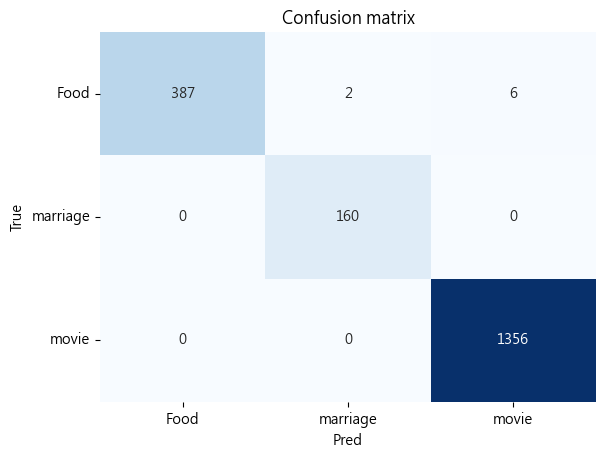

In [ ]:
## Plot confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(
    xlabel="Pred",
    ylabel="True",
    xticklabels=classes,
    yticklabels=classes,
    title="Confusion matrix",
)
plt.yticks(rotation=0)

### TF-IDF

改試試看使用 TF-IDF 的 DTM 來代表文章，訓練分類模型的效果

In [ ]:
vectorizer = TfidfVectorizer(max_features=1000)
vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)
vocabulary = vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame(columns = vocabulary, data = vec_train.toarray())
tfidf_df

,一人,一位,一半,一句,一同,一名,一堆,一場,一大,一幕,...,魔法,鮭魚,鮮甜,麥基,麻辣,黑人,黑暗,點了,點餐,鼓勵
0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.114106,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4452,0.0,0.0,0.000000,0.0,0.047581,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.048422
4453,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.052985,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4454,0.0,0.0,0.140344,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4455,0.0,0.0,0.000000,0.0,0.000000,0.0,0.128413,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [ ]:
clf.fit(vec_train, y_train)
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)

# results
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        Food       1.00      0.98      0.99       395
    marriage       1.00      0.99      0.99       160
       movie       0.99      1.00      1.00      1356

    accuracy                           0.99      1911
   macro avg       1.00      0.99      0.99      1911
weighted avg       0.99      0.99      0.99      1911



效果一樣也是不錯，可能因為三個版（婚姻、食物、電影）的內容本來就有很大的差異，用字遣詞會不同。

### CV

cross-validation 會自動切成 k 組 train-test dataset。  
`cross_validate()` 會回傳經過 cross-validation 的模型評估結果。

In [ ]:
clf = LogisticRegression()
vec_train = TfidfVectorizer(max_features=1000).fit_transform(X_train)

scores = cross_validate(clf, vec_train, y_train, cv=5, scoring=("f1_macro", "recall_macro", "precision_macro"), return_estimator=True)
pprint(scores)

{'estimator': [LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression()],
 'fit_time': array([0.05484843, 0.04591203, 0.04191947, 0.0478723 , 0.04188871]),
 'score_time': array([0.01991844, 0.01894808, 0.01695299, 0.0169549 , 0.01595688]),
 'test_f1_macro': array([0.98026145, 0.9828497 , 0.97949854, 0.97981554, 0.98895897]),
 'test_precision_macro': array([0.99429756, 0.99480789, 0.9953271 , 0.99481597, 0.9968652 ]),
 'test_recall_macro': array([0.96720061, 0.97158658, 0.9652459 , 0.96604736, 0.98137762])}


`cross_val_predict()` 則會回傳 cv 預測的類別。

In [ ]:
y_pred = cross_val_predict(clf, vec_train, y_train, cv=5)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

        Food       1.00      0.98      0.99       917
    marriage       1.00      0.93      0.97       378
       movie       0.99      1.00      0.99      3162

    accuracy                           0.99      4457
   macro avg       1.00      0.97      0.98      4457
weighted avg       0.99      0.99      0.99      4457



### 比較不同模型效果

In [ ]:
# 定義模型訓練組合
## pipeline: 資料處理 vectorizer + 分類器 clf
## 由於 cross-validation 會自動將資料分成 train/test，因此 input 只要給 X, y 即可

def train_cv(vectorizer, clf, X, y):

    ## train classifier
    vec_X = vectorizer.fit_transform(X).toarray()
    
    ## get cv results
    cv_results = cross_validate(clf, vec_X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, vec_X, y, cv=5)
    y_pred_proba = cross_val_predict(clf, vec_X, y, cv=5, method="predict_proba")
    
    ## Accuracy, Precision, Recall, F1-score
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))

    classes = cv_results['estimator'][0].classes_
    
    ## Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title= str(clf) + "Confusion matrix",
    )
    plt.yticks(rotation=0)

    clf.fit(vec_X, y)
    # return the model object
    return cls_report

              precision    recall  f1-score   support

        Food       1.00      0.98      0.99       917
    marriage       1.00      0.93      0.97       378
       movie       0.99      1.00      0.99      3162

    accuracy                           0.99      4457
   macro avg       1.00      0.97      0.98      4457
weighted avg       0.99      0.99      0.99      4457



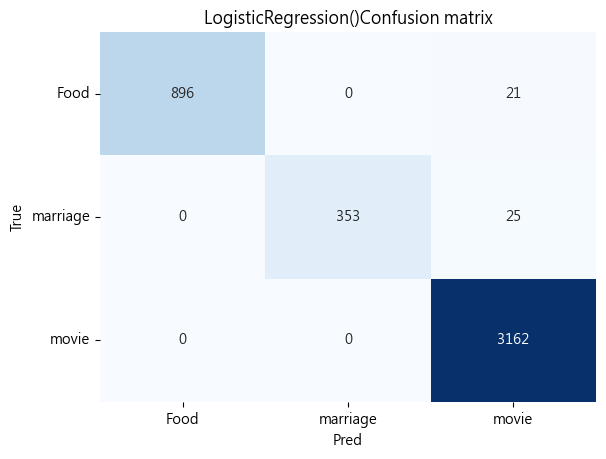

In [ ]:
vectorizer = TfidfVectorizer(max_features=1000)
clf = LogisticRegression()
result = train_cv(vectorizer, clf, X_train, y_train)

now training: clf_logistic
              precision    recall  f1-score   support

        Food       1.00      0.98      0.99       917
    marriage       1.00      0.93      0.97       378
       movie       0.99      1.00      0.99      3162

    accuracy                           0.99      4457
   macro avg       1.00      0.97      0.98      4457
weighted avg       0.99      0.99      0.99      4457

now training: clf_dtree
              precision    recall  f1-score   support

        Food       0.99      0.99      0.99       917
    marriage       0.94      0.95      0.94       378
       movie       0.99      0.99      0.99      3162

    accuracy                           0.99      4457
   macro avg       0.97      0.98      0.98      4457
weighted avg       0.99      0.99      0.99      4457

now training: clf_svm
              precision    recall  f1-score   support

        Food       1.00      0.99      1.00       917
    marriage       1.00      0.97      0.98       378
  

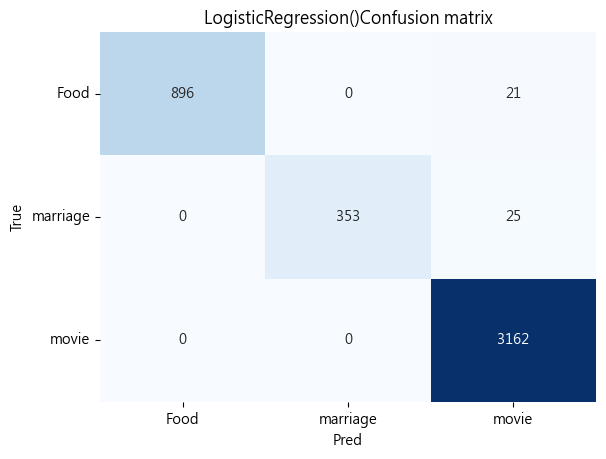

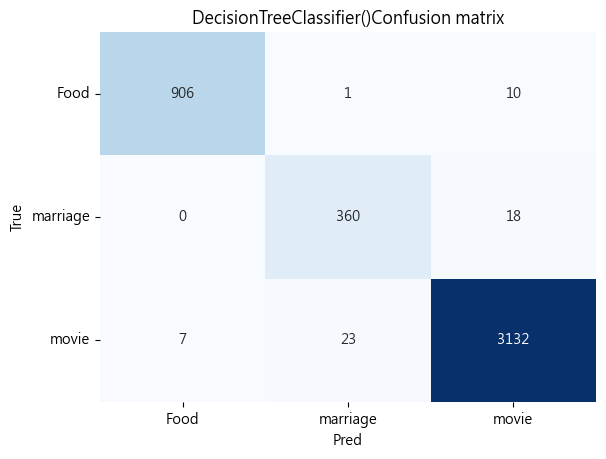

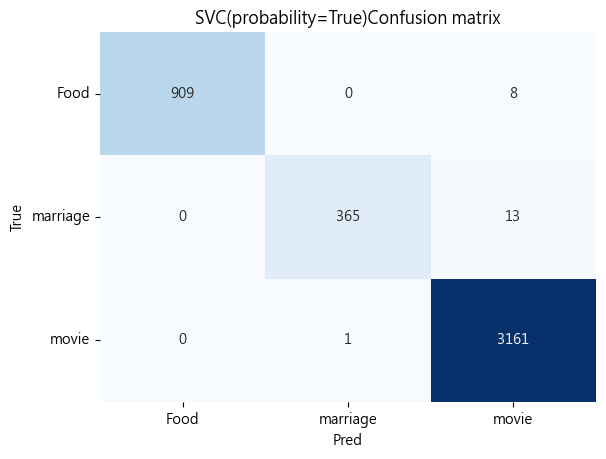

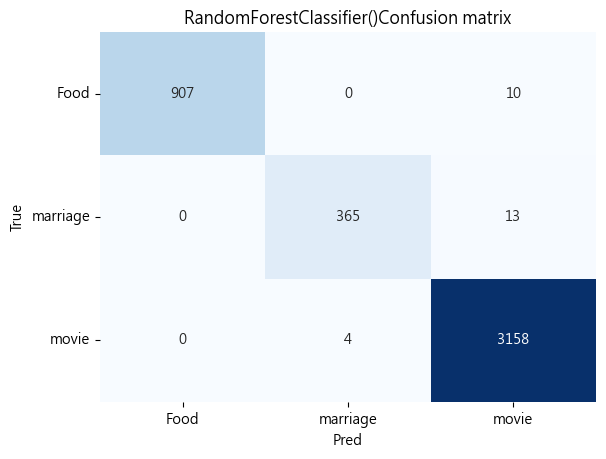

In [ ]:
# 準備訓練資料
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)
# 定義模型訓練組合
model_set = dict()
model_set['clf_logistic'] = LogisticRegression()
model_set['clf_dtree'] = DecisionTreeClassifier()
model_set['clf_svm'] = svm.SVC(probability=True) # 要使用SVM的predict_proba的話，必須在叫出SVC的時候就將probability設為True
model_set['clf_rf'] = RandomForestClassifier()
# 定義 vectorizer
# vectorizer = CountVectorizer(max_features=1000)
vectorizer = TfidfVectorizer(max_features=1000)
# 存結果
result_set = dict()

for k, model in model_set.items():
    print("="*100)
    print(f"now training: {k}")
    result_set[k] = train_cv(vectorizer, model, X_train, y_train)
    print("="*100)


分別觀察各個分類模型在不同類別的評估指標表現如何

In [ ]:
result_set['clf_logistic']

{'Food': {'precision': 1.0,
  'recall': 0.9770992366412213,
  'f1-score': 0.9884169884169884,
  'support': 917.0},
 'marriage': {'precision': 1.0,
  'recall': 0.9338624338624338,
  'f1-score': 0.9658002735978112,
  'support': 378.0},
 'movie': {'precision': 0.9856608478802993,
  'recall': 1.0,
  'f1-score': 0.9927786499215071,
  'support': 3162.0},
 'accuracy': 0.9896791563832175,
 'macro avg': {'precision': 0.9952202826267665,
  'recall': 0.9703205568345518,
  'f1-score': 0.9823319706454355,
  'support': 4457.0},
 'weighted avg': {'precision': 0.9898271485298421,
  'recall': 0.9896791563832175,
  'f1-score': 0.9895932180502931,
  'support': 4457.0}}

+ 找出f1-score表現最好的模型是哪個，作為我們最終得到的分類器

In [ ]:
max = 0
best_model_name = ""
best_model_metric = "f1-score"

## choose max f1-score model from result_set
for k, v in result_set.items():
    if v['weighted avg'][best_model_metric] > max:
        max = v['weighted avg'][best_model_metric]
        best_model_name = k
print(f"best model: {best_model_name}")
pprint(result_set[best_model_name])

best model: clf_svm
{'Food': {'f1-score': 0.9956188389923329,
          'precision': 1.0,
          'recall': 0.9912758996728462,
          'support': 917.0},
 'accuracy': 0.9950639443571909,
 'macro avg': {'f1-score': 0.9911112636864932,
               'precision': 0.9968893788947163,
               'recall': 0.9855227032489466,
               'support': 4457.0},
 'marriage': {'f1-score': 0.9811827956989247,
              'precision': 0.9972677595628415,
              'recall': 0.9656084656084656,
              'support': 378.0},
 'movie': {'f1-score': 0.9965321563682219,
           'precision': 0.9934003771213074,
           'recall': 0.9996837444655281,
           'support': 3162.0},
 'weighted avg': {'f1-score': 0.9950424614239354,
                  'precision': 0.9950862027310584,
                  'recall': 0.9950639443571909,
                  'support': 4457.0}}


In [ ]:
y_pred = model_set['clf_rf'].predict(vectorizer.transform(X_test).toarray())
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        Food       1.00      0.98      0.99       395
    marriage       1.00      1.00      1.00       160
       movie       0.99      1.00      1.00      1356

    accuracy                           1.00      1911
   macro avg       1.00      0.99      1.00      1911
weighted avg       1.00      1.00      1.00      1911



In [ ]:
model_set['clf_rf'].predict(vectorizer.transform(["菲律賓 大學 要求 帶防 作弊 憤怒 皮卡丘 同台 東森 新聞 菲律賓 一名 大學教授"]).toarray())

array(['movie'], dtype=object)

* 最佳的 model 為 Random Forest，其餘 model （Logistic、SVM、Decision Tree）表現差不多。

### 分析可解釋模型的結果

#### 各字詞特徵的迴歸係數
對於線性的模型，可以藉由相關係數，查看資料特徵（詞）對於判斷分類的影響
+ 迴歸係數（coefficient estimates）反映了每個特徵對預測結果的影響程度和方向。​當其他變數保持不變時，某一特徵的值增加一個單位（例如詞頻增加1），其對應的迴歸係數表示該特徵對事件發生機率的影響。
+ 計算後得到勝算比（odds ratio），這表示該特徵每增加一個單位，事件發生的勝算（odds）相對於未增加時的倍數變化。
+ 這裡用logistic regression + cv tokenizer 

In [ ]:
def plot_coef(logistic_reg_model, feature_names, top_n=10):
    # 選出某個類別的前10大影響力字詞
    log_odds = logistic_reg_model.coef_.T
    coef_df = pd.DataFrame(
        log_odds, 
        columns=logistic_reg_model.classes_, index=feature_names
    )
    for label in coef_df.columns:
        select_words = (
            coef_df[[label]]
            .sort_values(by=label, ascending=False)
            .iloc[np.r_[0:top_n, -top_n:0]]
        )
        word = select_words.index
        count = select_words[label]
        category_colors = np.where(
            select_words[label] >= 0, "darkseagreen", "rosybrown"
        )  # 設定顏色

        fig, ax = plt.subplots(figsize=(8, top_n*0.8))  # 設定畫布
        plt.rcParams["axes.unicode_minus"] = False

        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title(
            "Coeff increase/decrease odds ratio of 「" + label + "」 label the most",
            loc="left",
            size=16,
        )
        ax.set_ylabel("word", size=14)
        ax.set_xlabel("odds ratio", size=14)

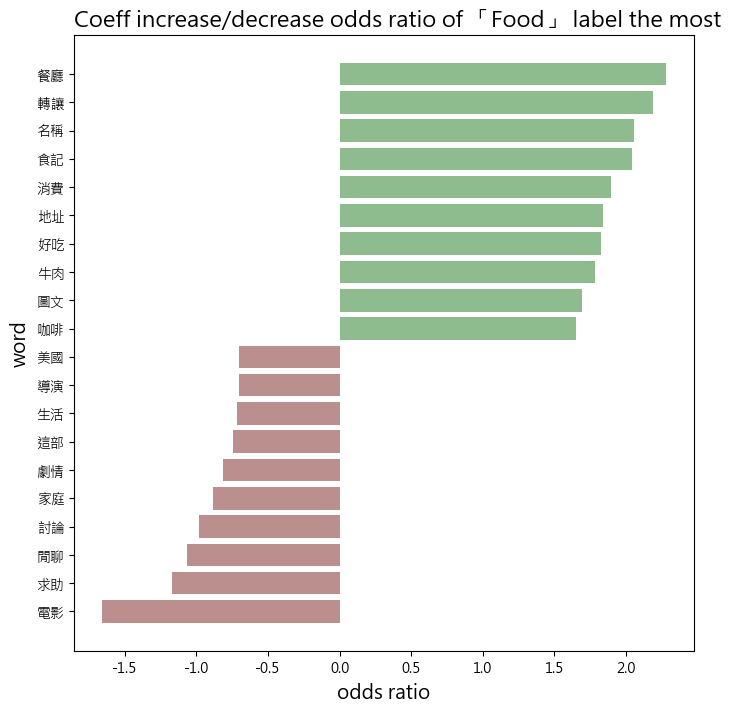

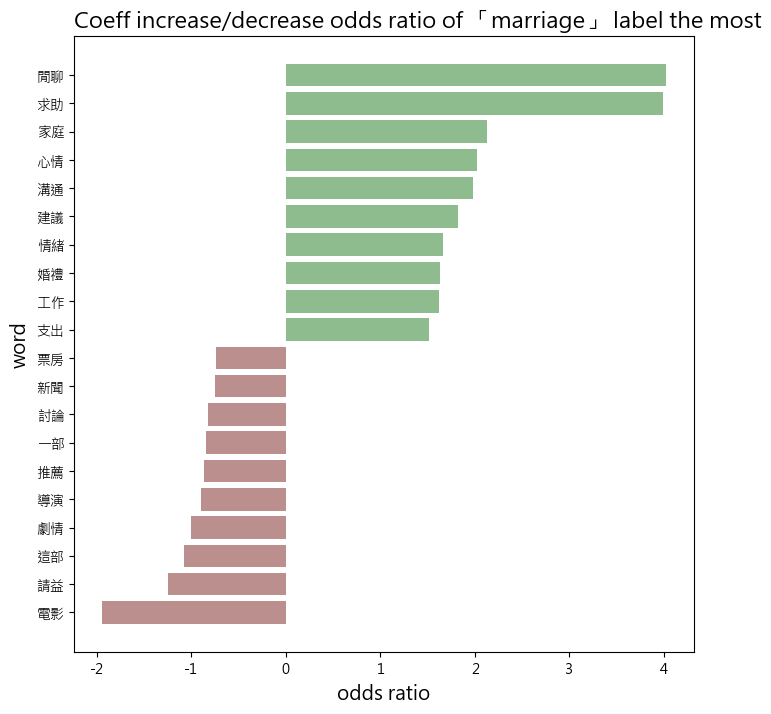

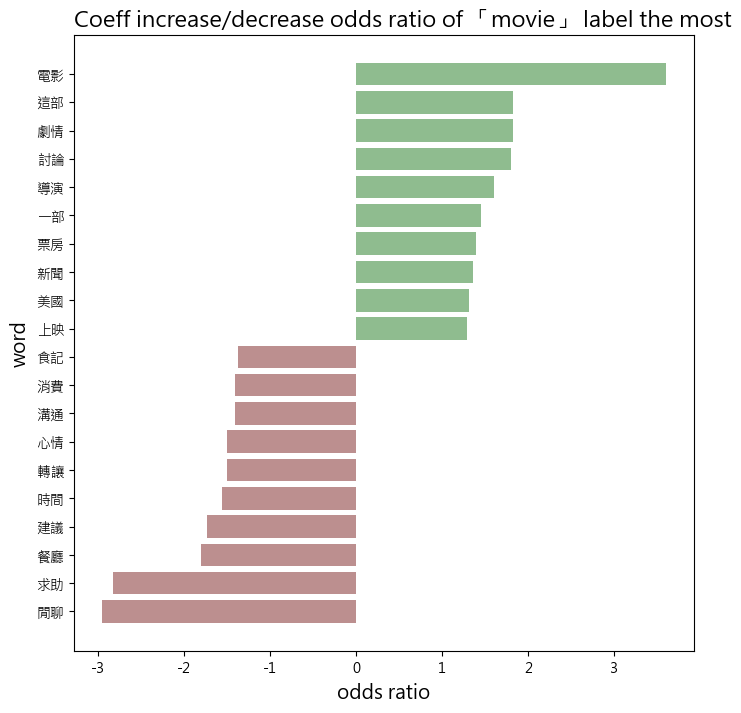

In [ ]:
plot_coef(logistic_reg_model=model_set['clf_logistic'], feature_names=vectorizer.get_feature_names_out(), top_n=10)

食物版中出現了餐廳、名稱、食記等關鍵字；婚姻版中高係數的字是閒聊、求助、結婚；電影版則是電影、討論、劇情相關的字。

# 以下還沒做(4/13)
 - 預計抓同樣板塊(也是食物、婚姻、電影)，不同時間的資料來測試分類的效果

## 6. 用訓練好的分類器來預測不同時間的文章類別

`marriage.csv` 為婚姻版資料`food.csv` 為食物版資料`movie.csv` 為電影版資料
- 版別：婚姻版 食物版 電影版
- 時間範圍：2024/07/01 ~ 2024/12/31
- 工作流程平台搜尋/排除關鍵字：無

In [ ]:
file_list = ["food.csv", "marriage.csv", "movie.csv"]
dfs = [pd.read_csv(f) for f in file_list]
ct = pd.concat(dfs, ignore_index=True)
ct.dropna(inplace=True)
ct

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Food/M.1719766782.A.1E8...,[食記]台中臭屁仙臭豆腐，蘿蔔糕才是重點,2024-07-01 00:59:39,minglong1985,Food,餐廳名稱：臭屁仙臭豆腐\n 消費時間：2024年/6月\n 地址：台中市南區建國南路...,[],220.132.134.131,2024-07-01 01:11:57,ptt
1,2,https://www.ptt.cc/bbs/Food/M.1719798509.A.3E0...,[轉讓]RAW7/1318:302位,2024-07-01 09:48:27,F1orance,Food,餐廳名稱：RAW Collective Memories\n 地址：台北市中山區樂群三路...,[],42.70.109.51,2024-07-02 01:11:54,ptt
3,4,https://www.ptt.cc/bbs/Food/M.1719801335.A.E9F...,[食記]桃園-日式精緻吃到飽-欣葉日式料理,2024-07-01 10:35:31,Guyinkt,Food,消費時間：2024年/05月\n\n說到日式吃到飽現在當然旭集當紅\n但可別忘了之前還有一家...,[],27.51.35.116,2024-07-02 01:11:54,ptt
4,5,https://www.ptt.cc/bbs/Food/M.1719816351.A.775...,[轉讓],2024-07-01 14:45:49,asewgek,Food,餐廳名稱：挽肉と米\n地址：台北市中山區忠孝東路二段9號\n訂位日期時間：07/02 13：...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""asewgek"", ""c...",118.231.185.228,2024-07-02 01:11:54,ptt
5,6,https://www.ptt.cc/bbs/Food/M.1719826239.A.56A...,[食記]西班牙巴塞隆納中餐廳-悅來小館煎餅果子,2024-07-01 17:30:37,vikimsw,Food,在西班牙巴塞隆納旅遊期間，\n\n想吃什麼就在谷歌查什麼，或者問問網友有沒有推薦的餐廳，\n...,[],1.200.14.6,2024-07-02 01:11:54,ptt
...,...,...,...,...,...,...,...,...,...,...,...
7384,5018,https://www.ptt.cc/bbs/movie/M.1735655285.A.D4...,[討論]2024結束了，但驚奇隊長的虧損還在持續,2024-12-31 22:28:02,hellofox,movie,今天是2024年的最後一天，好萊塢票房下半年在迪士尼《腦筋》、《海洋》等動畫片續集\n\n的...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""darkbrigher""...",223.139.253.243,2025-02-21 17:06:04,ptt
7385,5019,https://www.ptt.cc/bbs/movie/M.1735657556.A.1F...,[心得]2024進場觀影回顧,2024-12-31 23:05:54,roadrise,movie,２０２４最後一天做個回顧\n\n\n這已經是第三年寫回顧了\n\n\n去年進場看了５２部片（...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""leonEEman"", ...",59.115.193.130,2025-02-21 17:06:04,ptt
7386,5020,https://www.ptt.cc/bbs/movie/M.1735657665.A.DC...,[好雷]唐頓莊園DowntonAbbey2019電影,2024-12-31 23:07:43,zzauber,movie,雷文防雷資訊頁\n\n中華電信MOD上架\n\n《唐頓莊園》電影版，描述20世紀早期，擁有莊...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""gomotion"", ""...",180.217.210.37,2025-02-21 17:06:04,ptt
7387,5021,https://www.ptt.cc/bbs/movie/M.1735659247.A.A7...,[好雷]當哈利碰上莎莉,2024-12-31 23:34:05,tilwemeet,movie,"先祝大家新年快樂,希望大家渡過了開心的2024\n也希望電影之神接下來保佑我們遠離爛片接近神...","[{""cmtStatus"": ""→"", ""cmtPoster"": ""airflow"", ""c...",39.1.4.157,2025-02-21 17:06:04,ptt


In [ ]:
# 移除網址格式
ct["artContent"].str.replace("(http|https)://.*", "", regex=True)
ct["artTitle"].str.replace("(http|https)://.*", "", regex=True)
ct["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
ct["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)

# 留下 content
ct["content"] = ct["artTitle"] + ct["artContent"]
ct = ct.loc[:,["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

ct["words"] = ct["content"].apply(getToken).map(" ".join)
ct.head()

,content,artUrl,artCatagory,words
0,[食記]台中臭屁仙臭豆腐，蘿蔔糕才是重點餐廳名稱：臭屁仙臭豆腐\n 消費時間：2024年...,https://www.ptt.cc/bbs/Food/M.1719766782.A.1E8...,Food,食記 臭屁 臭豆腐 蘿蔔 重點 餐廳 名稱 臭屁 臭豆腐 消費 時間 2024 地址 台中市...
1,[轉讓]RAW7/1318:302位餐廳名稱：RAW Collective Memories...,https://www.ptt.cc/bbs/Food/M.1719798509.A.3E0...,Food,轉讓 RAW7 1318 302 餐廳 名稱 RAW Collective Memories...
3,[食記]桃園-日式精緻吃到飽-欣葉日式料理消費時間：2024年/05月\n\n說到日式吃到飽...,https://www.ptt.cc/bbs/Food/M.1719801335.A.E9F...,Food,食記 桃園 日式 精緻 欣葉 日式 料理 消費 時間 2024 05 日式 旭集 當紅 別忘...
4,[轉讓]餐廳名稱：挽肉と米\n地址：台北市中山區忠孝東路二段9號\n訂位日期時間：07/02...,https://www.ptt.cc/bbs/Food/M.1719816351.A.775...,Food,轉讓 餐廳 名稱 挽肉 地址 台北市 山區 忠孝東路 訂位 日期 時間 07 02 13 0...
5,[食記]西班牙巴塞隆納中餐廳-悅來小館煎餅果子在西班牙巴塞隆納旅遊期間，\n\n想吃什麼就在...,https://www.ptt.cc/bbs/Food/M.1719826239.A.56A...,Food,食記 西班牙 巴塞隆納 中餐廳 悅來 小館 煎餅果子 西班牙 巴塞隆納 旅遊 期間 歌查 問...


觀察一下資料集的分佈狀況

In [ ]:
ct['artCatagory'].value_counts()

artCatagory
movie       4958
Food        1650
marriage     684
Name: count, dtype: int64

將東森的新聞類別給重新mapping到我們分類器的類別，接著開始進行分類任務

因為label相同無須重新mapping

In [ ]:
X = ct['words']
y = ct['artCatagory']

y_pred = model_set[best_model_name].predict(vectorizer.transform(X).toarray())
print(classification_report(y, y_pred))



              precision    recall  f1-score   support

        Food       1.00      0.98      0.99      1650
    marriage       0.97      0.86      0.91       684
       movie       0.98      1.00      0.99      4958

    accuracy                           0.98      7292
   macro avg       0.98      0.95      0.96      7292
weighted avg       0.98      0.98      0.98      7292



從classification report可以發現，在東森新聞的資料集上，前面訓練得到的分類器在這邊表現並不好

接著進一步研究分類的結果，嘗試找出問題的原因

In [ ]:
ct['pred'] = y_pred
ct.loc[:,['words', 'artCatagory',"pred"]]

,words,artCatagory,pred
0,食記 臭屁 臭豆腐 蘿蔔 重點 餐廳 名稱 臭屁 臭豆腐 消費 時間 2024 地址 台中市...,Food,Food
1,轉讓 RAW7 1318 302 餐廳 名稱 RAW Collective Memories...,Food,Food
3,食記 桃園 日式 精緻 欣葉 日式 料理 消費 時間 2024 05 日式 旭集 當紅 別忘...,Food,Food
4,轉讓 餐廳 名稱 挽肉 地址 台北市 山區 忠孝東路 訂位 日期 時間 07 02 13 0...,Food,Food
5,食記 西班牙 巴塞隆納 中餐廳 悅來 小館 煎餅果子 西班牙 巴塞隆納 旅遊 期間 歌查 問...,Food,Food
...,...,...,...
7384,討論 2024 結束 驚奇 隊長 虧損 還在 持續 2024 好萊塢 票房 下半年 迪士尼 ...,movie,movie
7385,心得 2024 進場 觀影 回顧 做個 回顧 第三年 回顧 去年 進場 部片 一刷 週末 行...,movie,movie
7386,好雷 唐頓 莊園 DowntonAbbey2019 電影 雷文 防雷 資訊 中華電信 MOD...,movie,movie
7387,好雷 哈利 碰上 莎莉 先祝 新年快樂 希望 渡過 開心 2024 希望 電影 之神 保佑 ...,movie,movie


將錯誤分類的結果篩選出來

In [ ]:
false_pred = ct.query("artCatagory != pred").loc[:,['words', 'artCatagory',"pred"]]
false_pred

,words,artCatagory,pred
6,請益 雙北有 調味 日式 燒肉 事先 調味 鹽醬 醬汁 的燒 肉店 單點 雙北 必填 新台幣...,Food,movie
47,廣宣 新竹 竹北 NextStop 香港 手作 料理店 Next Stop 香港 手作 料理...,Food,movie
113,徵人 20 中午 君悅 漂亮 廣式 餐廳 位一 意願 訊息,Food,movie
170,請益 森森 燒肉 vs 老井 價位 服務 味道 燒烤 森森 vs 老井 請問 推薦 價位 差...,Food,movie
173,徵人 天本 363 天本 363 熟客 後續 開放 訂位 私訊 同捆 12 00 優先 私訊 告知,Food,movie
...,...,...,...
5840,Fw 閒聊 萊恩 雷諾 女浩克 金剛 戲份 砍光 作者 kimisawa 楊回 Chat 閒...,movie,marriage
6296,Re 閒聊 萊恩 雷諾 女浩克 金剛 戲份 砍光 消息 串流 封面 死侍 女浩克 圖片 取代...,movie,marriage
6362,普雷 短片 收攤 雲端 消防隊 很近 很遠 工作 家庭 衡量 之重 事少 離家近 工作 夢幻...,movie,marriage
6803,Fw 閒聊 變種 天賦 女主艾瑪 杜蒙 性別 作者 s24066774 JJ Chat 閒聊...,movie,marriage


觀察看看婚姻版的文章，模型給出的分類結果怎麼樣

In [ ]:
false_pred.loc[false_pred['artCatagory']=='marriage', :].head(20)

,words,artCatagory,pred
1694,政見 RuRu0421 個人資料 查詢 網友 暱稱 RuRu0421 小淵澤報 企鵝 經濟 ...,marriage,movie
1702,政見 amilkamilk 個人資料 暱稱 amilkamilk 我要 幹話 經濟 小康 登...,marriage,movie
1715,政見 charles6416 個人資料 暱稱 charles6416 0.0 經濟 小康 登...,marriage,movie
1716,Re 求助 調適 雙薪 後援 坐牢 41Y 38Y 時人 迎來 寶貝女兒 產假 育嬰 留停 ...,marriage,movie
1732,Re 求助 岳父 岳母 身心 障礙 最佳解 外勞 美國 姊姊 現實 時間 談不攏 姊姊 出點...,marriage,movie
1743,Re 社交 續瓜 正常人 導正 思想 沒想到 歪樓 簡單 網友 風向 網友 點多 睡覺 回文...,marriage,movie
1744,Re 社交 續瓜 澄清 坦蕩蕩 質疑 人格 做法 你還 乾脆 大方 出軌 當成 給你 報復 ...,marriage,movie
1747,Re 社交 續瓜 洗澡 瓦斯 拿來 煮飯 兩桶 瓦斯 一桶 一桶 先頂 著用 付出 超出 分...,marriage,movie
1753,Re 求助 變得 浪漫 浪漫 帶你去 參加 球團 聚餐 還不忘 盛湯 夾菜 頭髮 稱讚 髮型...,marriage,movie
1754,Re 求助 變得 浪漫 心理學 課本 浪漫 肉體 長久 象徵 溫暖 關懷 友伴 長久 丈夫 ...,marriage,movie


挑選一篇婚姻版的文章觀察看看內容，為何模型會將其分類成電影版的文章

In [ ]:
pprint(false_pred['words'][1754])

('Re 求助 變得 浪漫 心理學 課本 浪漫 肉體 長久 象徵 溫暖 關懷 友伴 長久 丈夫 溝通 明說 生悶氣 殺手 加油 加油 友伴 愛為 浪漫 愛為 '
 '加油 加油')


這篇文章實際在討論伴侶關係中的情感問題，如「丈夫」「夥伴」「溝通」「關懷」「長久」等詞都與婚姻有關。但模型因為看到像「浪漫」「心理學」「象徵」「殺手」這些詞，容易聯想到愛情電影、劇情分析或角色設定，因此誤以為是 movie 類文章。模型缺乏對語境的理解，只根據詞頻與關鍵字進行判斷，導致分類失準。

## 第九週：主題模型（中文） <br>

本週課程為 **主題模型** ，學習如何將文本進行主題模型分析。<br>
文件主題模型採用非監督式學習的方式，不事先人為做標籤與註解，訓練的資料是從資料文本得來，讓我們可以規模化給予大量文本，而訓練出主題模型，其中最為知名為LDA模型，也是本次課程主要的教學目標，本 jupyter notebook 是以中文文本為示範。<br>
這次課程分為幾個部分：
1. 將資料進行前處理 
2. lexicon-based 的主題模型
3. LDA 主題模型 
4. 視覺化主題模型 
5. GuidedLDA
6. 主題模型的應用

## 1. 套件說明
本次實作過程中使用到的相關套件，在課堂中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
+ gensim: 主題模型函式庫
+ pyLDAvis: 互動式LDA視覺化套件

In [ ]:
import time 
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models

In [ ]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
# 設定中文字體
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示

## 2. 資料前處理

In [ ]:
udn = pd.read_csv("raw_data/text.csv")  # 匯資料
udn.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,safelove,marriage,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""FlyOncidium""...",114.137.169.105,2021-01-10 01:20:56,ptt
1,2,https://www.ptt.cc/bbs/marriage/M.1610162736.A...,Re:老公工作不穩定,2021-01-09 11:25:34,mayko,marriage,"因為男方工作不穩定,房東才不肯租,只好換女生承租,對吧\n很殘忍的說...這無緣的孩子聰明,...",[],36.229.84.229,2021-01-10 01:20:56,ptt
2,3,https://www.ptt.cc/bbs/marriage/M.1610190309.A...,Re:[求助]真的可以不給看手機嗎？,2021-01-09 19:05:00,loser1,marriage,手機要看就給看啊！\n先帝爺不是說，\n一隻不夠，不能辦兩隻嗎？\n兩隻不夠，不能辦三隻嗎？...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""mark0204"", ""...",118.170.238.138,2021-01-10 01:20:56,ptt


In [ ]:
# 移除網址格式
# 只留下中文字
udn["artContent"] = udn["artContent"].str.replace("(http|https)://.*", "", regex=True)
udn["artTitle"] = udn["artTitle"].str.replace("(http|https)://.*", "", regex=True)
udn["artContent"] = udn["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
udn["artTitle"] = udn["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
udn['artDate'] = pd.to_datetime(udn['artDate'])
udn['content'] = udn['artContent']


udn = udn.loc[:,["content", "artUrl", "artCatagory", 'artDate']]  # 文章內容 文章連結
udn.head(3)

,content,artUrl,artCatagory,artDate
0,常常看大家說偷看手機是不對的但如果已經結婚了太太想看你手機真的可以拒絕嗎感覺你拒絕就是心裡有...,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,marriage,2021-01-09 10:37:05
1,因為男方工作不穩定房東才不肯租只好換女生承租對吧很殘忍的說這無緣的孩子聰明來到這世間只是苦難...,https://www.ptt.cc/bbs/marriage/M.1610162736.A...,marriage,2021-01-09 11:25:34
2,手機要看就給看啊先帝爺不是說一隻不夠不能辦兩隻嗎兩隻不夠不能辦三隻嗎三隻四隻不夠可以辦五隻十...,https://www.ptt.cc/bbs/marriage/M.1610190309.A...,marriage,2021-01-09 19:05:00


In [ ]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

stopWords.extend(["覺得", "真的", "現在", "問題", "知道", "事情", "應該", "需要", "比較", "工作"])
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

udn["words"] = udn["content"].apply(getToken)
udn.head()

Building prefix dict from /Users/hank/Desktop/SMA_2025S/week09/dict/dict.txt.big ...
2025-04-15 23:33:50,630 : DEBUG : Building prefix dict from /Users/hank/Desktop/SMA_2025S/week09/dict/dict.txt.big ...
Loading model from cache /var/folders/8v/d43rjw7s49s8tg2qbw5vxr1h0000gn/T/jieba.u4d327844f04abaf5ca9f6002d061e27b.cache
2025-04-15 23:33:50,633 : DEBUG : Loading model from cache /var/folders/8v/d43rjw7s49s8tg2qbw5vxr1h0000gn/T/jieba.u4d327844f04abaf5ca9f6002d061e27b.cache
Loading model cost 0.417 seconds.
2025-04-15 23:33:51,049 : DEBUG : Loading model cost 0.417 seconds.
Prefix dict has been built successfully.
2025-04-15 23:33:51,050 : DEBUG : Prefix dict has been built successfully.


,content,artUrl,artCatagory,artDate,words
0,常常看大家說偷看手機是不對的但如果已經結婚了太太想看你手機真的可以拒絕嗎感覺你拒絕就是心裡有...,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,marriage,2021-01-09 10:37:05,"[偷看, 手機, 已經, 結婚, 太太, 手機, 拒絕, 感覺, 拒絕, 心裡, 有鬼, 太..."
1,因為男方工作不穩定房東才不肯租只好換女生承租對吧很殘忍的說這無緣的孩子聰明來到這世間只是苦難...,https://www.ptt.cc/bbs/marriage/M.1610162736.A...,marriage,2021-01-09 11:25:34,"[男方, 穩定, 房東, 不肯, 只好, 女生, 承租, 殘忍, 無緣, 孩子, 聰明, 來..."
2,手機要看就給看啊先帝爺不是說一隻不夠不能辦兩隻嗎兩隻不夠不能辦三隻嗎三隻四隻不夠可以辦五隻十...,https://www.ptt.cc/bbs/marriage/M.1610190309.A...,marriage,2021-01-09 19:05:00,"[手機, 給看, 先帝, 一隻, 不夠, 兩隻, 兩隻, 不夠, 三隻, 三隻, 四隻, 不..."
3,其實都是小事但都可以吵到離婚可能我們就是幾歲的小孩昨晚上床睡覺後一直覺得很冷老公也喊冷想說睡...,https://www.ptt.cc/bbs/marriage/M.1610193770.A...,marriage,2021-01-09 20:02:46,"[小事, 吵到, 離婚, 幾歲, 小孩, 昨晚, 上床, 睡覺, 一直, 老公, 冷想, 溫..."
4,把棉被翻好正面嗯嗯有嗯那你幹嘛抱怨你老公不是誰上床睡覺還會檢查棉被正反的嗎我我也覺得你半夜叫...,https://www.ptt.cc/bbs/marriage/M.1610203445.A...,marriage,2021-01-09 22:44:03,"[棉被, 正面, 幹嘛, 抱怨, 老公, 上床, 睡覺, 還會, 檢查, 棉被, 正反, 半..."


## 3. Lexicon-based / 人工給定主題的主題模型

In [ ]:
udn['artCatagory'].unique()

array(['marriage'], dtype=object)

#### 用各個主題常見的詞來作為主題的代表詞

In [ ]:
## 定義主題
cnt = udn.loc[udn['artCatagory'] == 'marriage',:]['words'].explode().value_counts().head(100)
cnt.index

Index(['小孩', '離婚', '老婆', '老公', '先生', '孩子', '婚姻', '結婚', '對方', '太太', '一起', '已經',
       '生活', '家庭', '時間', '媽媽', '想要', '建議', '一直', '不想', '希望', '一下', '婆婆', '兩個',
       '一定', '父母', '溝通', '最後', '照顧', '願意', '房子', '直接', '之後', '情緒', '看到', '一點',
       '朋友', '無法', '辦法', '女方', '夫妻', '關係', '不用', '喜歡', '好好', '完全', '爸媽', '接受',
       '一次', '選擇', '感覺', '認為', '男方', '東西', '改變', '要求', '只能', '吵架', '處理', '爸爸',
       '我媽', '討論', '根本', '回家', '一些', '發現', '是否', '想法', '狀況', '人生', '繼續', '雙方',
       '不好', '感情', '幫忙', '女生', '來說', '方式', '公婆', '還要', '重要', '相處', '目前', '之前',
       '男人', '努力', '女兒', '決定', '兒子', '這是', '每天', '壓力', '能力', '在家', '婆家', '解決',
       '經濟', '家人', '這件', '娘家'],
      dtype='object', name='words')

In [ ]:
custom_topic_word = {
    "外遇": [
        "小三", "出軌", "偷吃", "劈腿", "外遇" , "小王", "小三", "抓姦", "偷情", "通姦", "感情", "曖昧", "劈腿", "出軌", "婚外情", 
        "背叛", "精神出軌", "肉體出軌", "酒店", "性愛", "情人", "桃色", "偷吃", "性關係","偷看"
        "夜歸", "異性朋友", "不倫戀", "密會", "私訊", "聊天紀錄", "手機密碼", "軟體交友", "曖昧訊息", "破裂"
    ],
    "小孩": [
        "撫養權", "探視", "孩子", "教育費", "未成年"
    ],
    "公婆": [
        "婆婆", "公公", "家庭糾紛", "干涉", "長輩"
    ],
    "金錢": [
        "財產", "贍養費", "登記", "收入", "房貸"
    ]
}



從 custom_topic_word 的所有值中，整理出不重複的詞彙（vocabularies），並以 NumPy 陣列的形式儲存。

In [ ]:
vocabularies = np.unique(reduce(lambda x, y: x + y, custom_topic_word.values()))

In [ ]:
vocabularies

array(['不倫戀', '偷吃', '偷情', '偷看夜歸', '公公', '出軌', '劈腿', '外遇', '婆婆', '婚外情',
       '孩子', '家庭糾紛', '密會', '小三', '小王', '干涉', '性愛', '性關係', '情人', '感情',
       '房貸', '手機密碼', '抓姦', '探視', '撫養權', '收入', '教育費', '曖昧', '曖昧訊息', '未成年',
       '桃色', '異性朋友', '登記', '破裂', '私訊', '精神出軌', '聊天紀錄', '肉體出軌', '背叛', '財產',
       '贍養費', '軟體交友', '通姦', '酒店', '長輩'], dtype='<U4')

利用 CountVectorizer 的 vocabulary 參數來篩選、製作 DTM

In [ ]:
udn_corpus = udn['words'].map(" ".join)
vectorizer = CountVectorizer(vocabulary=vocabularies)
udn_matrix = vectorizer.fit_transform(udn_corpus)

udn_matrix = udn_matrix.toarray()
feature_names = vectorizer.get_feature_names_out()

DTM_df = pd.DataFrame(columns = feature_names, data = udn_matrix)
DTM_df

,不倫戀,偷吃,偷情,偷看夜歸,公公,出軌,劈腿,外遇,婆婆,婚外情,...,精神出軌,聊天紀錄,肉體出軌,背叛,財產,贍養費,軟體交友,通姦,酒店,長輩
0,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2199,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2200,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2201,0,0,0,0,0,0,0,0,13,0,...,0,0,0,0,0,0,0,0,0,0
2202,0,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,1


針對每個「自定義主題」，統計每篇文章在該主題下出現的詞彙總次數，整理成一個DataFrame

In [ ]:
df_count = pd.DataFrame({})

# k 是主題名稱，v 是這個主題下的詞彙list
for k, v in custom_topic_word.items():
    idx = np.isin(
        feature_names,
        v
    )
    df_count[f'topic_{k}'] = udn_matrix[:, idx].sum(axis=1)
    
df_count

,topic_外遇,topic_小孩,topic_公婆,topic_金錢
0,2,0,0,0
1,0,3,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
2199,1,0,0,0
2200,0,0,0,0
2201,0,0,13,0
2202,0,0,4,0


把每篇文章在各個主題的出現次數轉換成主題分佈機率（比例），也就是 每篇文章屬於各個主題的相對權重（theta 向量）

In [ ]:
thetas = df_count.div(
    df_count.sum(axis=1),
    axis=0
)
thetas

,topic_外遇,topic_小孩,topic_公婆,topic_金錢
0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
2199,1.0,0.0,0.0,0.0
2200,NaN,NaN,NaN,NaN
2201,0.0,0.0,1.0,0.0
2202,0.0,0.0,1.0,0.0


## 4. LDA 主題模型
Latent Dirichlet allocation 簡稱 LDA，是一種主題模型，他可以將資料集中每篇文檔的主題按照機率分佈，他是無監督學習法，訓練時不需要手動標註，只需要給文檔集、主題數，也可以根據一些參數(alpha、Beta)來改變模型訓練的結果，以下使用 gensim 套件來示範如何訓練 LDA 模型。

簡單的範例說明 `gensim` bag of word 的方式

### **4.1 正式處理離婚**

將斷詞後的`doc['words']`轉換成list

In [ ]:
docs = udn['words'].to_list()
docs[0]

['偷看',
 '手機',
 '已經',
 '結婚',
 '太太',
 '手機',
 '拒絕',
 '感覺',
 '拒絕',
 '心裡',
 '有鬼',
 '太太',
 '猜忌',
 '日子',
 '難過',
 '手機',
 '隨便',
 '太太',
 '每次',
 '提心吊膽',
 '已經',
 '小心',
 '總是',
 '疏忽',
 '太太',
 '看到',
 '想要',
 '離婚',
 '證據',
 '特別',
 '之前',
 '點到',
 '止僅',
 '止於',
 '肉體',
 '出軌',
 '最近',
 '遇到',
 '喜歡',
 '對象',
 '已經',
 '發展',
 '精神',
 '出軌',
 '還要',
 '躲躲藏藏',
 '很累',
 '問問',
 '說服',
 '另一半',
 '保有',
 '隱私',
 '對方',
 '手機']

建立並過濾詞彙表（dictionary），只保留特定條件的詞彙

In [ ]:
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

2025-04-15 23:38:15,799 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2025-04-15 23:38:15,953 : INFO : built Dictionary<39978 unique tokens: ['之前', '保有', '偷看', '出軌', '另一半']...> from 2204 documents (total 380070 corpus positions)
2025-04-15 23:38:15,954 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<39978 unique tokens: ['之前', '保有', '偷看', '出軌', '另一半']...> from 2204 documents (total 380070 corpus positions)", 'datetime': '2025-04-15T23:38:15.953994', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-15.3.2-arm64-arm-64bit', 'event': 'created'}
2025-04-15 23:38:15,965 : INFO : discarding 32254 tokens: [('提心吊膽', 4), ('止僅', 1), ('止於', 4), ('躲躲藏藏', 1), ('點到', 3), ('不放', 4), ('外學', 1), ('大師', 2), ('找不出', 2), ('承租', 2)]...
2025-04-15 23:38:15,965 : INFO : keeping 7724 tokens which were in no less than 5 and no more than 2181 (=99.0%) documents
2025-04-15 23:38:15,970 : INFO : resulting 

Dictionary<7724 unique tokens: ['之前', '保有', '偷看', '出軌', '另一半']...>


參數說明：
- no_below=5	出現在少於 5 篇文章中的詞會被移除
- no_above=0.99	出現在超過 99% 文件中的詞會被移除

In [ ]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

之前: 0
保有: 1
偷看: 2
出軌: 3
另一半: 4
問問: 5
喜歡: 6
太太: 7
對方: 8
對象: 9
小心: 10
已經: 11


將斷詞結果建構語料庫(corpus)之後，利用語料庫把每篇文章數字化。<br>
每個詞彙都被賦予一個 ID 及頻率(word_id，word_frequency)。<br>

舉例來說：<br>
第一篇文章數字化結果為：corpus[600]:[(2, 2), (6, 1), (20, 2), .... ]，element 為文章中每個詞彙的 id 和頻率。<br>
代表：'世界'出現2次、'之戰'出現一次...以此類推

In [ ]:
pprint(" ".join(udn['words'].iloc[610]))


('顏色 控制 碼請 刪掉 小調 自認 盡力 老婆 常嫌 地板 擦乾淨 修正 老婆 清潔 要求 吵起來 沒完沒了 家事 部分 溝通 解決 建議 家事 分配 '
 '妥當 不知 原有 雙方 看到 通常 懶惰 一方 另一方 另一方 做太多 爆氣 同上 優化 處理 優化 狀態 老婆 討論 地板 乾淨 先擦給 之後 學習 '
 '遺憾 一輩子 想想看 老婆 溝通 自我 改變 延續 一點 所謂 完整 時間 關進 房間 只管 讀書 在家 從來不 完整 時間 嘗試 考試 心態 考試 '
 '時間 縫隙 唸書 提高 薪水 有益於 家庭收入 老婆 體諒 無解 收入 解套 一直 孩子 是種 傷害 夫妻間 冷漠 以待 影響 孩子 發展 上種 上述 '
 '短時間 無法 提升 繼續 下去 離婚 互不 退讓 雙方 辦法 改善 家事 收入 分享 一下 家事 執行 收入 分配 想要 一起 討論 清楚 一點 看到 '
 '一直 家事 關係 引爆 老婆 的點 家事 不斷 同事 老公 多好 這部分 解決 老婆 顧家 婚後 每年 孝親 嘲笑 學歷 低收入 當初 願意 兩個 小孩 '
 '原本 感情 不錯 家事 耗掉 感情 原原 文章 推文 投資 會花 時間 想要 賺錢 努力 程度 不亞於 考國考 當初 研究 股票 十來 雜誌 下手 股市 '
 '隨便 一張 吃掉 年薪 審慎 最後 新手 槓桿 尤其 整體 原原 個性 不太 適合 槓桿')


第600篇文章的前十個詞彙的語料庫ID和頻率

In [ ]:
dictionary.doc2bow(udn['words'].iloc[610])[:10]

[(14, 2),
 (25, 1),
 (26, 2),
 (35, 1),
 (37, 1),
 (52, 2),
 (82, 2),
 (86, 1),
 (112, 1),
 (136, 2)]

#### 將docs轉換成BOW形式
- 把每篇文件的 token list 轉換成一組 (token_id, count) 的 list

In [ ]:
# 建立 Bag-of-words 作為文章的特徵表示
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]

### **4.2 開始訓練 LDA topic model**

+ 參數說明：
    + corpus = 文檔語料庫
    + id2word = 詞彙字典
    + num_topics = 生成幾個主題數
    + random_state = 固定亂數值，每次的模型結果會一樣
    + iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
    + passes(epoch) = 整個 corpus 訓練模型的次數
    + alpha = 文章主題分佈
    + eta = 主題字分佈

模型參數沒有一個絕對的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整，進而比較出較佳的模型結果。

In [ ]:
ldamodel = LdaModel(
    corpus=corpus, 
    id2word=dictionary, # 字典
    num_topics=4, # 生成幾個主題數
    random_state=2024, # 亂數
)

2025-04-15 23:44:18,336 : INFO : using symmetric alpha at 0.25
2025-04-15 23:44:18,338 : INFO : using symmetric eta at 0.25
2025-04-15 23:44:18,341 : INFO : using serial LDA version on this node
2025-04-15 23:44:18,344 : INFO : running online (single-pass) LDA training, 4 topics, 1 passes over the supplied corpus of 2204 documents, updating model once every 2000 documents, evaluating perplexity every 2204 documents, iterating 50x with a convergence threshold of 0.001000
2025-04-15 23:44:18,345 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2025-04-15 23:44:18,346 : INFO : PROGRESS: pass 0, at document #2000/2204
2025-04-15 23:44:18,710 : INFO : merging changes from 2000 documents into a model of 2204 documents
2025-04-15 23:44:18,711 : INFO : topic #0 (0.250): 0.021*"小孩" + 0.008*"先生" + 0.008*"離婚" + 0.006*"太太" + 0.005*"老婆" + 0.005*"老公" + 0.005*"建議" + 0.005*"時間" + 0.004*"婚姻" + 0.004*"家庭"
2025-04-15 23:4

### **4.3 查看 LDA 主題代表字** <br>

當 LDA 模型訓練好之後，我們可以查看每個主題的單詞分佈。<br>
num_words = 選擇要查看每個主題前幾個字。<br>

舉例來說：<br>
`'0.020*"經典賽" + 0.014*"中華隊" + 0.011*"今天" + 0.009*"比賽" + 0.009*"日本" + 0.007*"棒球" + 0.007*"世界" + 0.007*"投手" + 0.006*"先發" + 0.005*"球隊"'`  

In [ ]:
ldamodel.print_topics()

2025-04-15 23:45:26,603 : INFO : topic #0 (0.250): 0.027*"小孩" + 0.012*"先生" + 0.009*"家庭" + 0.008*"太太" + 0.006*"時間" + 0.005*"離婚" + 0.005*"媽媽" + 0.005*"我媽" + 0.004*"兩個" + 0.004*"一定"
2025-04-15 23:45:26,605 : INFO : topic #1 (0.250): 0.011*"小孩" + 0.009*"離婚" + 0.009*"老婆" + 0.008*"老公" + 0.007*"太太" + 0.006*"婚姻" + 0.006*"家庭" + 0.006*"結婚" + 0.005*"對方" + 0.004*"媽媽"
2025-04-15 23:45:26,606 : INFO : topic #2 (0.250): 0.015*"小孩" + 0.012*"離婚" + 0.011*"孩子" + 0.009*"老公" + 0.005*"媽媽" + 0.005*"先生" + 0.005*"對方" + 0.005*"已經" + 0.005*"老婆" + 0.005*"房子"
2025-04-15 23:45:26,606 : INFO : topic #3 (0.250): 0.016*"老婆" + 0.015*"小孩" + 0.013*"離婚" + 0.010*"先生" + 0.007*"孩子" + 0.006*"家庭" + 0.006*"一起" + 0.006*"女方" + 0.006*"老公" + 0.005*"媽媽"


[(0,
  '0.027*"小孩" + 0.012*"先生" + 0.009*"家庭" + 0.008*"太太" + 0.006*"時間" + 0.005*"離婚" + 0.005*"媽媽" + 0.005*"我媽" + 0.004*"兩個" + 0.004*"一定"'),
 (1,
  '0.011*"小孩" + 0.009*"離婚" + 0.009*"老婆" + 0.008*"老公" + 0.007*"太太" + 0.006*"婚姻" + 0.006*"家庭" + 0.006*"結婚" + 0.005*"對方" + 0.004*"媽媽"'),
 (2,
  '0.015*"小孩" + 0.012*"離婚" + 0.011*"孩子" + 0.009*"老公" + 0.005*"媽媽" + 0.005*"先生" + 0.005*"對方" + 0.005*"已經" + 0.005*"老婆" + 0.005*"房子"'),
 (3,
  '0.016*"老婆" + 0.015*"小孩" + 0.013*"離婚" + 0.010*"先生" + 0.007*"孩子" + 0.006*"家庭" + 0.006*"一起" + 0.006*"女方" + 0.006*"老公" + 0.005*"媽媽"')]

也可以使用 `get_document_topics()` 回去看每篇文章的主題分佈 (`theta`)

In [ ]:
ldamodel.get_document_topics(corpus[0])

[(3, 0.28148574), (9, 0.70308477)]

這邊可以看到corpus[0]這篇文章是由多個主題混合組成，每個主題都有其機率（權重）
其中主題4的佔比最高(0.77)

### **4.4 查看 LDA 模型指標**
+ **Pointwise Mutual Information (PMI)** : <br>
自然語言處理中，想要探討兩個字之間是否存在某種關係。<br>
例如：某些字會一起出現，可能帶有某些訊息，因此這個可以用 PMI 來計算，數字越大越好。
+ **perplexity** :<br>
perplexity 也是評估的指標之一，廣泛用於語言模型的評估，意思為複雜度，因此數字要越小越好。

In [ ]:
# perplexity
perplexity = ldamodel.log_perplexity(corpus)
perplexity

2025-04-15 23:28:07,653 : INFO : -8.085 per-word bound, 271.5 perplexity estimate based on a held-out corpus of 2204 documents with 346189 words


-8.084902593513718

將 對數 perplexity 值轉回原始的 perplexity 值

In [ ]:
np.exp2(-perplexity)

271.5177291003625

In [ ]:
# npmi
NPMI_model_lda = CoherenceModel(model=ldamodel, texts=docs, coherence='c_npmi')
NPMI_lda = NPMI_model_lda.get_coherence()
print('這個主題模型的 PMI score: ', NPMI_lda)

2025-04-15 23:28:07,664 : INFO : using ParallelWordOccurrenceAccumulator<processes=9, batch_size=64> to estimate probabilities from sliding windows
/Users/hank/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/hank/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/hank/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/hank/Library/Python/3.9/lib/pyth

這個主題模型的 PMI score:  -0.012717552338231334


也可以列出主題模型中，每個主題詞語之間的PMI score

In [ ]:
NPMI_model_lda.get_coherence_per_topic()

[-0.024061666081922724,
 -0.01281621409326362,
 -0.004486795612168821,
 -0.010484843832570005,
 -0.009870863144836633,
 -0.008319880593692416,
 -0.027773252269809173,
 -0.008165420859028442,
 -0.01401537135124594,
 -0.0071812155437755544]

`NPMI` 的值域是[-1,1]，-1 代表兩個字沒一起出現過，0 代表兩個字之間獨立，1 代表兩個字完全相關

### **4.5 透過指標找出最佳主題數**

透過建立不同主題數的模型，並以上述所說的**判斷指標**來找出最佳的主題數。<br>
這裡我們選擇主題數 2~10 來做分析。

**再次強調**：主題數及參數沒有一個絕對正確的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整、主題數的調整，進而比較出較佳的模型結果。

In [ ]:
t0 = time.time()

topic_num_list = np.arange(2, 10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5 # 訓練次數
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")


2025-04-15 23:28:12,605 : INFO : using symmetric alpha at 0.5
2025-04-15 23:28:12,605 : INFO : using symmetric eta at 0.5
2025-04-15 23:28:12,607 : INFO : using serial LDA version on this node
2025-04-15 23:28:12,608 : INFO : running online (multi-pass) LDA training, 2 topics, 5 passes over the supplied corpus of 2204 documents, updating model once every 2000 documents, evaluating perplexity every 2204 documents, iterating 50x with a convergence threshold of 0.001000
2025-04-15 23:28:12,608 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2025-04-15 23:28:12,609 : INFO : PROGRESS: pass 0, at document #2000/2204
2025-04-15 23:28:13,008 : INFO : merging changes from 2000 documents into a model of 2204 documents
2025-04-15 23:28:13,009 : INFO : topic #0 (0.500): 0.022*"小孩" + 0.012*"離婚" + 0.009*"覺得" + 0.009*"老公" + 0.009*"老婆" + 0.008*"真的" + 0.007*"問題" + 0.007*"先生" + 0.006*"知道" + 0.006*"現在"
2025-04-15 23:28:1

花費時間: 61.0603928565979 sec


訓練要花一點時間，同學可以研究看看平行運算的 `gensim.models.ldamulticore.LdaMulticore()` class 或是其他方法

In [ ]:
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,2370.501647,-0.014425
1,3,2434.517755,-0.012754
2,4,2449.934849,-0.011682
3,5,2499.459067,-0.009877
4,6,2533.537519,-0.007903
5,7,2569.179636,-0.007042
6,8,2574.666482,-0.010552
7,9,2595.188680,-0.016099


<Axes: xlabel='topic_num'>

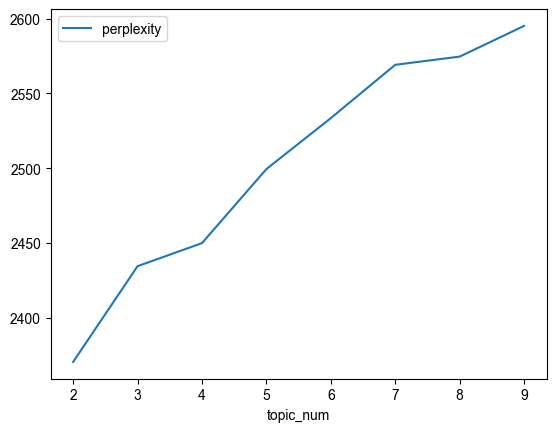

In [ ]:
result.plot.line(x='topic_num', y='perplexity')

<Axes: xlabel='topic_num'>

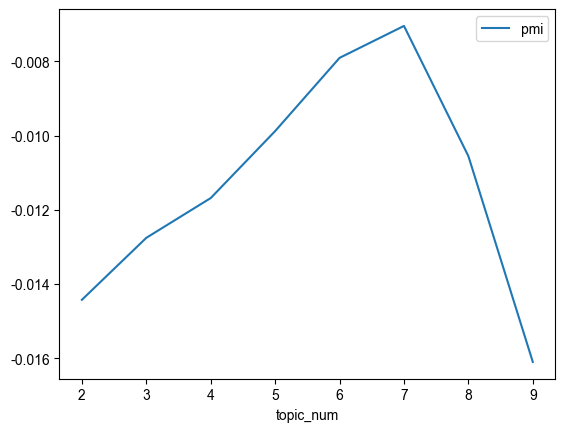

In [ ]:
result.plot.line(x='topic_num', y='pmi')

就訓練結果來看，perplexity 在 5 之後都不錯，coherence 最高則是 8

## 5. 視覺化呈現

LDAvis 是我們經常會使用的視覺化工具，目的為幫助我們解釋主題模型中，在我們建構好主題模型得到 θ(文件的主題分佈) 跟 φ(主題的字分佈)，透過 pyLDAvis 將主題降維成二維，以網頁的形式供我們查看。

+ 圓圈數量代表主題數量，有幾個主題就會有幾個圓圈
+ 圓越大代表 document 越大
+ 右邊可以看到主題的字分佈
+ 右上幫有一個 bar 調整 lambda：當 lambda=1 也就是代表本來的字分佈 φ，將 lambda 縮越小可以看到越唯一的字，好的分佈是 φ 高且唯一，因此我們要在這兩者間取平衡
+ 圓心越相近，代表主題會越相似；反之，圓心分越開代表主題有唯一性<br>
  --> 假設詞彙本來有 100 字，維度應該是 100，假如本來維度接近(相近)的話，降維後也會接近(相近)

以下用主題數 8 來做 LDAvis 的結果範例

In [ ]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 4,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )

2025-04-16 00:17:51,257 : INFO : using symmetric alpha at 0.25
2025-04-16 00:17:51,258 : INFO : using symmetric eta at 0.25
2025-04-16 00:17:51,261 : INFO : using serial LDA version on this node
2025-04-16 00:17:51,266 : INFO : running online (multi-pass) LDA training, 4 topics, 5 passes over the supplied corpus of 2204 documents, updating model once every 2000 documents, evaluating perplexity every 2204 documents, iterating 50x with a convergence threshold of 0.001000
2025-04-16 00:17:51,266 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2025-04-16 00:17:51,269 : INFO : PROGRESS: pass 0, at document #2000/2204
2025-04-16 00:17:51,626 : INFO : merging changes from 2000 documents into a model of 2204 documents
2025-04-16 00:17:51,627 : INFO : topic #0 (0.250): 0.020*"小孩" + 0.013*"老公" + 0.012*"老婆" + 0.008*"離婚" + 0.007*"對方" + 0.005*"想要" + 0.005*"結婚" + 0.004*"婚姻" + 0.004*"一起" + 0.004*"溝通"
2025-04-16 00:17

In [ ]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.020435  0.129892       1        1  31.296326
3      0.040550 -0.043206       2        1  28.688654
1     -0.121714 -0.059170       3        1  21.632619
2      0.101599 -0.027515       4        1  18.382401, topic_info=     Term         Freq        Total Category  logprob  loglift
295    老婆  3177.000000  3177.000000  Default  30.0000  30.0000
1031   女方  1014.000000  1014.000000  Default  29.0000  29.0000
7      太太  1348.000000  1348.000000  Default  28.0000  28.0000
66     男方   813.000000   813.000000  Default  27.0000  27.0000
200    先生  2176.000000  2176.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
250    接受   170.963650   731.960825   Topic4  -5.8596   0.2395
945    一起   198.224287  1554.980298   Topic4  -5.7116  -0.3660
234    建議   171.464911   857.077279   Topic4  -5.8567   0.0846
14     想要   174.716747  1081.121558   Topic4  -5.8379  -0.1288
665    生活   169.525008  1195.159203   Topic4  -5.8680  -0.2593

[387 rows x 6 columns], token_table=      Topic      Freq Term
term                      
381       1  0.353041   一下
381       2  0.206852   一下
381       3  0.154145   一下
381       4  0.285416   一下
5049      1  0.047200  一兩年
...     ...       ...  ...
5502      1  0.973019   餅乾
1294      1  0.789544   餐廳
1294      2  0.102176   餐廳
1294      3  0.083599   餐廳
1294      4  0.027866   餐廳

[848 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3])

可以看到(7,8)、(3,6)和(2,5)很相近，試試看跑5個主題

In [ ]:
model_5 = LdaModel(
    corpus = corpus,
    num_topics = 3,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model_5, corpus, dictionary)
p

2025-04-16 00:32:54,177 : INFO : using symmetric alpha at 0.3333333333333333
2025-04-16 00:32:54,178 : INFO : using symmetric eta at 0.3333333333333333
2025-04-16 00:32:54,179 : INFO : using serial LDA version on this node
2025-04-16 00:32:54,182 : INFO : running online (multi-pass) LDA training, 3 topics, 5 passes over the supplied corpus of 2204 documents, updating model once every 2000 documents, evaluating perplexity every 2204 documents, iterating 50x with a convergence threshold of 0.001000
2025-04-16 00:32:54,182 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2025-04-16 00:32:54,183 : INFO : PROGRESS: pass 0, at document #2000/2204
2025-04-16 00:32:54,563 : INFO : merging changes from 2000 documents into a model of 2204 documents
2025-04-16 00:32:54,564 : INFO : topic #0 (0.333): 0.021*"小孩" + 0.012*"老公" + 0.010*"老婆" + 0.008*"離婚" + 0.007*"對方" + 0.005*"婚姻" + 0.005*"結婚" + 0.005*"先生" + 0.004*"想要" +

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.057088  0.087101       1        1  39.117001
2     -0.049137 -0.091559       2        1  31.127273
1      0.106225  0.004458       3        1  29.755726, topic_info=     Term         Freq        Total Category  logprob  loglift
1031   女方   985.000000   985.000000  Default  30.0000  30.0000
7      太太  1363.000000  1363.000000  Default  29.0000  29.0000
66     男方   793.000000   793.000000  Default  28.0000  28.0000
52     孩子  1685.000000  1685.000000  Default  27.0000  27.0000
589    房子   912.000000   912.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
11     已經   322.373860  1314.593268   Topic3  -5.7069  -0.1934
14     想要   305.045373  1057.983206   Topic3  -5.7622  -0.0315
628    時間   297.982054  1346.489082   Topic3  -5.7856  -0.2961
1133   朋友   268.538633   722.416766   Topic3  -5.8897   0.2225
234    建議   268.797615   854.849252   Topic3  -5.8887   0.0552

[306 rows x 6 columns], token_table=      Topic      Freq Term
term                      
381       1  0.412409   一下
381       2  0.378539   一下
381       3  0.208197   一下
444       1  0.332497   一定
444       2  0.318298   一定
...     ...       ...  ...
6217      1  0.992875   飯店
6217      3  0.007465   飯店
1294      1  0.866475   餐廳
1294      2  0.043324   餐廳
1294      3  0.091461   餐廳

[614 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

替換主題數跑看看，可以看出最佳參數的數字和人類判斷的不一定會相符，所以為了更好的觀察文本中的資訊，逐步、循環的調整是很重要的

lambda 的意義: <https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf>

In [ ]:
pyLDAvis.save_html(p, "lda_zh.html")

## 6. GuidedLDA

- 原始套件: <https://github.com/vi3k6i5/GuidedLDA>  
- 31lab 家銘修改版本: <https://github.com/Text-Analytics-and-Retrieval/GuidedLDA>

安裝方式:  
`pip install git+https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git#egg=GuidedLDA`  
經測試，在 `python3.7~3.11.0` 可正常執行

In [ ]:
import guidedlda

In [ ]:
word2id = dictionary.token2id
print(dictionary)

Dictionary<7724 unique tokens: ['之前', '保有', '偷看', '出軌', '另一半']...>


In [ ]:
seed_topic_list = [
    # 外遇（出軌、情感背叛）
    ["出軌", "小三", "偷吃", "通姦", "曖昧", "外遇", "綠茶", "小王"],

    # 小孩（教養、親權爭奪）
    ["小孩", "孩子", "撫養", "監護權", "扶養費", "教育費", "探視"],

    # 公婆（家庭關係、長輩干涉）
    ["婆婆",  "長輩", "干涉", "婆媳", "岳母", "公公", "娘家", "夫家"],

    # 金錢（財產分配、經濟壓力）
    ["財產", "贍養費", "房貸", "貸款", "收入", "登記", "財務", "金流"]
]


In [ ]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [ ]:
# guidedlda 需要 DTM 格式作為 input，因此這邊利用 corpus2dense() 方法進行轉換
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

In [ ]:
model = guidedlda.GuidedLDA(n_topics=4, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2025-04-16 00:02:15,053 : INFO : n_documents: 2204
2025-04-16 00:02:15,055 : INFO : vocab_size: 7724
2025-04-16 00:02:15,056 : INFO : n_words: 326051
2025-04-16 00:02:15,056 : INFO : n_topics: 4
2025-04-16 00:02:15,056 : INFO : n_iter: 100
2025-04-16 00:02:15,862 : INFO : <0> log likelihood: -3113218
2025-04-16 00:02:16,024 : INFO : <20> log likelihood: -2747314
2025-04-16 00:02:16,185 : INFO : <40> log likelihood: -2722854
2025-04-16 00:02:16,347 : INFO : <60> log likelihood: -2711267
2025-04-16 00:02:16,506 : INFO : <80> log likelihood: -2705684
2025-04-16 00:02:16,664 : INFO : <99> log likelihood: -2700037


In [ ]:
# 整理／顯示主題模型結果
n_top_words = 10
topic_word = model.topic_word_
vocab = [dictionary[i] for i in range(len(dictionary))]

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_ # 文件-主題 分佈
term_freq = tuple(dictionary.cfs.values()) # 每個詞在整個語料中出現的總次數
doc_len = [sum(v for k, v in doc) for doc in corpus] # 每篇文章的長度

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 離婚 婚姻 對方 老公 太太 先生 關係 情緒 想要 溝通
Topic 1: 小孩 孩子 老婆 老公 時間 媽媽 照顧 離婚 生活 一起
Topic 2: 先生 老婆 婆婆 老公 我媽 爸媽 結婚 婆家 直接 公婆
Topic 3: 離婚 老婆 小孩 房子 女方 結婚 男方 先生 老公 家庭


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.140889  0.131270       1        1  35.040175
1     -0.091180 -0.247579       2        1  23.787704
3      0.187059 -0.031925       3        1  21.237859
2     -0.236768  0.148233       4        1  19.934261, topic_info=     Term         Freq        Total Category  logprob  loglift
112    小孩  5282.000000  5282.000000  Default  30.0000  30.0000
52     孩子  1849.000000  1849.000000  Default  29.0000  29.0000
295    老婆  3433.000000  3433.000000  Default  28.0000  28.0000
1779   婆婆   934.000000   934.000000  Default  27.0000  27.0000
200    先生  2254.000000  2254.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
40     不想   282.699521   977.112540   Topic4  -5.4377   0.3725
11     已經   303.676482  1302.814685   Topic4  -5.3661   0.1564
37     離婚   364.609561  4150.061658   Topic4  -5.1833  -0.8193
26     看到   254.730238   769.327245   Topic4  -5.5419   0.5074
945    一起   244.741209  1335.778260   Topic4  -5.5819  -0.0843

[313 rows x 6 columns], token_table=      Topic      Freq Term
term                      
381       1  0.247641   一下
381       2  0.363690   一下
381       3  0.190653   一下
381       4  0.198942   一下
444       1  0.509171   一定
...     ...       ...  ...
332       4  0.178257   願意
6217      4  1.000408   飯店
175       4  1.000431   飲料
1294      3  0.011772   餐廳
1294      4  0.988855   餐廳

[463 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3])

In [ ]:
seed_topic_list = [
    # 外遇（出軌、情感背叛）
    ["出軌", "小三", "偷吃", "通姦", "曖昧", "外遇", "綠茶", "小王"],

    # 小孩（教養、親權爭奪）
    ["小孩", "孩子", "撫養", "監護權", "扶養費", "教育費", "探視"],

    # 公婆（家庭關係、長輩干涉）
    ["婆婆",  "長輩", "干涉", "婆媳", "岳母", "公公", "娘家", "夫家"],

    # 金錢（財產分配、經濟壓力）
    ["財產", "贍養費", "房貸", "貸款", "收入", "登記", "財務", "金流"]
]


seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [ ]:
model = guidedlda.GuidedLDA(n_topics=4, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2025-04-16 00:04:08,790 : INFO : n_documents: 2204
2025-04-16 00:04:08,791 : INFO : vocab_size: 7724
2025-04-16 00:04:08,791 : INFO : n_words: 326051
2025-04-16 00:04:08,792 : INFO : n_topics: 4
2025-04-16 00:04:08,792 : INFO : n_iter: 100
2025-04-16 00:04:09,624 : INFO : <0> log likelihood: -3113218
2025-04-16 00:04:09,791 : INFO : <20> log likelihood: -2747314
2025-04-16 00:04:09,952 : INFO : <40> log likelihood: -2722854
2025-04-16 00:04:10,112 : INFO : <60> log likelihood: -2711267
2025-04-16 00:04:10,271 : INFO : <80> log likelihood: -2705684
2025-04-16 00:04:10,430 : INFO : <99> log likelihood: -2700037


In [ ]:
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 離婚 婚姻 對方 老公 太太 先生 關係 情緒 想要 溝通
Topic 1: 小孩 孩子 老婆 老公 時間 媽媽 照顧 離婚 生活 一起
Topic 2: 先生 老婆 婆婆 老公 我媽 爸媽 結婚 婆家 直接 公婆
Topic 3: 離婚 老婆 小孩 房子 女方 結婚 男方 先生 老公 家庭


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.140889  0.131270       1        1  35.040175
1     -0.091180 -0.247579       2        1  23.787704
3      0.187059 -0.031925       3        1  21.237859
2     -0.236768  0.148233       4        1  19.934261, topic_info=     Term         Freq        Total Category  logprob  loglift
112    小孩  5282.000000  5282.000000  Default  30.0000  30.0000
52     孩子  1849.000000  1849.000000  Default  29.0000  29.0000
295    老婆  3433.000000  3433.000000  Default  28.0000  28.0000
1779   婆婆   934.000000   934.000000  Default  27.0000  27.0000
200    先生  2254.000000  2254.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
40     不想   282.699521   977.112540   Topic4  -5.4377   0.3725
11     已經   303.676482  1302.814685   Topic4  -5.3661   0.1564
37     離婚   364.609561  4150.061658   Topic4  -5.1833  -0.8193
26     看到   254.730238   769.327245   Topic4  -5.5419   0.5074
945    一起   244.741209  1335.778260   Topic4  -5.5819  -0.0843

[313 rows x 6 columns], token_table=      Topic      Freq Term
term                      
381       1  0.247641   一下
381       2  0.363690   一下
381       3  0.190653   一下
381       4  0.198942   一下
444       1  0.509171   一定
...     ...       ...  ...
332       4  0.178257   願意
6217      4  1.000408   飯店
175       4  1.000431   飲料
1294      3  0.011772   餐廳
1294      4  0.988855   餐廳

[463 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3])

## 7. 主題分佈的應用，搭配其他文章資訊

訓練完LDA模型後，我們可以嘗試將訓練好的模型應用於資料集上，觀察每天主題文章的佔比變化

In [ ]:
# 取得每條新聞的主題分佈
topics_doc = model_5.get_document_topics(corpus)

In [ ]:
topics_doc[100]

[(0, 0.5605979), (1, 0.23947774), (2, 0.19992433)]

#### 將 LDA 模型推論後的每篇文件的 主題分布（也就是 𝜃）轉換成一個 NumPy 矩陣（array）

In [ ]:
# 把 gensim 的稀疏表示法轉成稀疏矩陣
m_theta = corpus2csc(topics_doc).T.toarray() # 倒置讓shape變為(num_docs, num_topics)
m_theta

array([[0.62762403, 0.        , 0.36388329],
       [0.07755699, 0.64984453, 0.27259848],
       [0.40168506, 0.57119024, 0.0271247 ],
       ...,
       [0.99608099, 0.        , 0.        ],
       [0.77657616, 0.        , 0.21992192],
       [0.98283869, 0.        , 0.        ]])

In [ ]:
# 將主題的機率分布轉換成主題標籤
udn['topic_label'] = m_theta.argmax(axis=1) + 1

#### 統計一下各個主題的數量

In [ ]:
udn['topic_label'].value_counts()

topic_label
1    875
2    750
3    579
Name: count, dtype: int64

In [ ]:
udn.head()

,content,artUrl,artCatagory,artDate,words,topic_label
0,常常看大家說偷看手機是不對的但如果已經結婚了太太想看你手機真的可以拒絕嗎感覺你拒絕就是心裡有...,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,marriage,2021-01-09 10:37:05,"[偷看, 手機, 已經, 結婚, 太太, 手機, 拒絕, 感覺, 拒絕, 心裡, 有鬼, 太...",1
1,因為男方工作不穩定房東才不肯租只好換女生承租對吧很殘忍的說這無緣的孩子聰明來到這世間只是苦難...,https://www.ptt.cc/bbs/marriage/M.1610162736.A...,marriage,2021-01-09 11:25:34,"[男方, 穩定, 房東, 不肯, 只好, 女生, 承租, 殘忍, 無緣, 孩子, 聰明, 來...",2
2,手機要看就給看啊先帝爺不是說一隻不夠不能辦兩隻嗎兩隻不夠不能辦三隻嗎三隻四隻不夠可以辦五隻十...,https://www.ptt.cc/bbs/marriage/M.1610190309.A...,marriage,2021-01-09 19:05:00,"[手機, 給看, 先帝, 一隻, 不夠, 兩隻, 兩隻, 不夠, 三隻, 三隻, 四隻, 不...",2
3,其實都是小事但都可以吵到離婚可能我們就是幾歲的小孩昨晚上床睡覺後一直覺得很冷老公也喊冷想說睡...,https://www.ptt.cc/bbs/marriage/M.1610193770.A...,marriage,2021-01-09 20:02:46,"[小事, 吵到, 離婚, 幾歲, 小孩, 昨晚, 上床, 睡覺, 一直, 老公, 冷想, 溫...",1
4,把棉被翻好正面嗯嗯有嗯那你幹嘛抱怨你老公不是誰上床睡覺還會檢查棉被正反的嗎我我也覺得你半夜叫...,https://www.ptt.cc/bbs/marriage/M.1610203445.A...,marriage,2021-01-09 22:44:03,"[棉被, 正面, 幹嘛, 抱怨, 老公, 上床, 睡覺, 還會, 檢查, 棉被, 正反, 半...",1


#### 查看每天每個主題的文章相對比例（占比）

In [ ]:
udn.groupby(udn['artDate'].dt.date)['topic_label'].value_counts(normalize=True)


artDate     topic_label
2021-01-09  1              0.571429
            4              0.285714
            3              0.142857
2021-01-10  1              0.428571
            2              0.285714
                             ...   
2024-12-30  1              0.750000
            2              0.250000
2024-12-31  1              0.500000
            2              0.250000
            4              0.250000
Name: proportion, Length: 1383, dtype: float64

In [ ]:
date_topic = udn.groupby(udn['artDate'].dt.date)['topic_label'].value_counts(normalize=True).unstack()
date_topic.head()

topic_label,1,2,3
artDate,,,
2021-01-09,0.571429,0.285714,0.142857
2021-01-10,0.571429,0.285714,0.142857
2021-01-11,NaN,NaN,1.000000
2021-01-12,NaN,1.000000,NaN
2021-01-13,0.500000,0.500000,NaN


#### 視覺化呈現主題文章趨勢變化

/var/folders/8v/d43rjw7s49s8tg2qbw5vxr1h0000gn/T/ipykernel_48197/4047522323.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = date_topic.resample('M').mean()


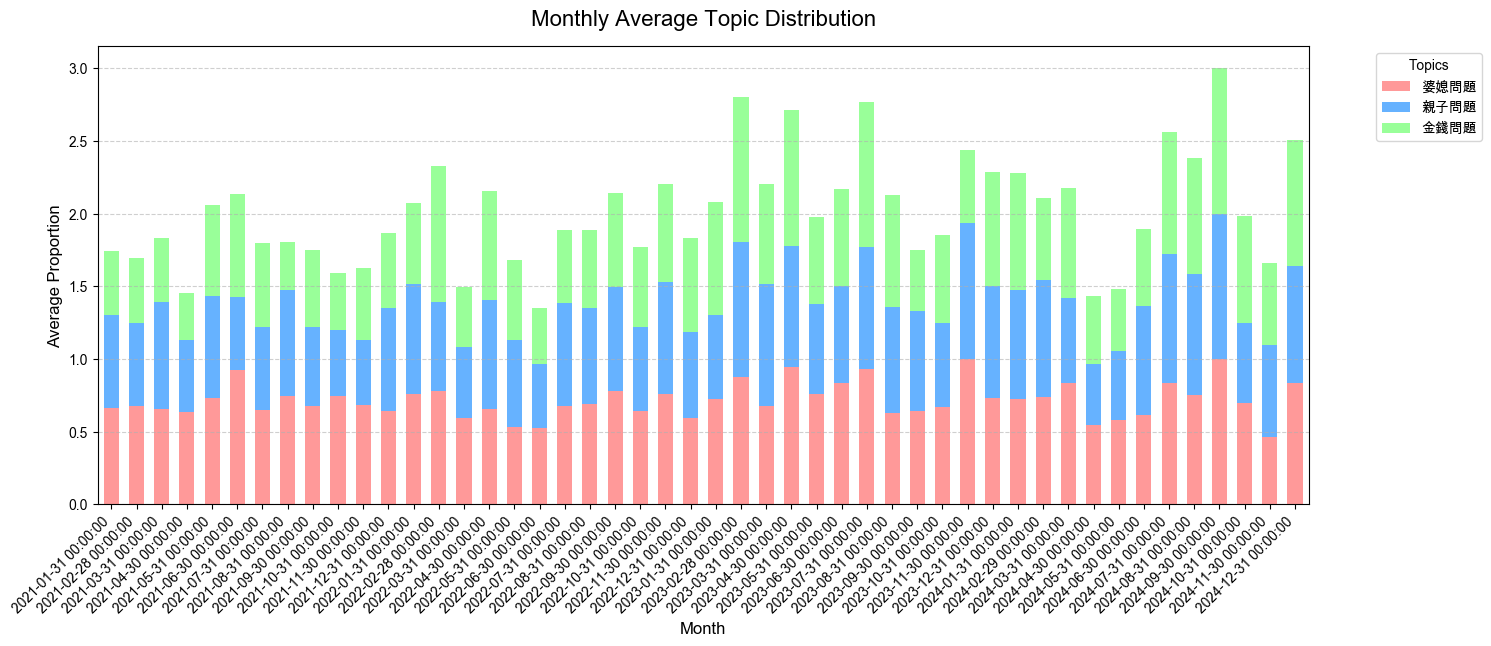

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 確保 index 是 datetime
date_topic.index = pd.to_datetime(date_topic.index)

# 依月份取平均（會自動按每月分組）
monthly_avg = date_topic.resample('M').mean()

# 畫圖（堆疊 bar）
plt.figure(figsize=(15, 6))
ax = plt.gca()

monthly_avg.plot.bar(
    ax=ax,
    stacked=True,
    color=['#FF9999', '#66B2FF', '#99FF99', '#FFCC99'],
    width=0.6
)

# 標題與格式設定
plt.title('Monthly Average Topic Distribution', fontsize=16, pad=15)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Proportion', fontsize=12)

# 調整圖例
plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), 
           labels=['婆媳問題', '親子問題', '金錢問題'])

# 美化
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()


可以看到主題3（中國各產業市場）在 2/15、2/16 被討論的比例很高，可以作為後續探索的目標，<br>
大家可以像這樣，透過搭配文章的資訊（例如日期等），讓主題模型的結果做出更多的分析應用。